In [1]:
import functools
import logging
import pprint
import traceback
from argparse import ArgumentParser, Namespace, FileType
import copy
import os
from functools import partial
import warnings
from typing import Mapping, Optional

import yaml

# Ignore pandas deprecation warning around pyarrow
warnings.filterwarnings("ignore", category=DeprecationWarning,
                        message="(?s).*Pyarrow will become a required dependency of pandas.*")

import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader

from rdkit import RDLogger
from rdkit.Chem import RemoveAllHs

# TODO imports are a little odd, utils seems to shadow things
from utils.logging_utils import configure_logger, get_logger
import utils.utils
from datasets.process_mols import write_mol_with_coords
from utils.download import download_and_extract
from utils.diffusion_utils import t_to_sigma as t_to_sigma_compl, get_t_schedule
from utils.inference_utils import InferenceDataset, set_nones
from utils.sampling import randomize_position, sampling
from utils.utils import get_model
from utils.visualise import PDBFile
from tqdm import tqdm

if os.name != 'nt':  # The line does not work on Windows
    import resource
    rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
    resource.setrlimit(resource.RLIMIT_NOFILE, (64000, rlimit[1]))


/home/gbnam/anaconda3/envs/diffdock_test_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # set to gpu 2
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 2 to use

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print('Device:', device)
# print('Current cuda device:', torch.cuda.current_device())
# print('Count of using GPUs:', torch.cuda.device_count())

# set to gpu 1-2
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 1 to use

# Define the device
device_id = 0  # GPU 1
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Limit the memory usage to 8GB
torch.cuda.set_per_process_memory_fraction(0.5, device_id)

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda:0
Current cuda device: 0
Count of using GPUs: 1


In [3]:
RDLogger.DisableLog('rdApp.*')

warnings.filterwarnings("ignore", category=UserWarning,
                        message="The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`")

# Prody logging is very verbose by default
prody_logger = logging.getLogger(".prody")
prody_logger.setLevel(logging.ERROR)

REPOSITORY_URL = os.environ.get("REPOSITORY_URL", "https://github.com/gcorso/DiffDock")
REMOTE_URLS = [f"{REPOSITORY_URL}/releases/latest/download/diffdock_models.zip",
               f"{REPOSITORY_URL}/releases/download/v1.1/diffdock_models.zip"]


def get_parser():
    parser = ArgumentParser()
    parser.add_argument('--config', type=FileType(mode='r'), default='default_inference_args.yaml')
    parser.add_argument('--protein_ligand_csv', type=str, default='./data/inputs/protein_ligand_input_0051.csv', help='Path to a .csv file specifying the input as described in the README. If this is not None, it will be used instead of the --protein_path, --protein_sequence and --ligand parameters')
    # parser.add_argument('--protein_ligand_csv', type=str, default=None, help='Path to a .csv file specifying the input as described in the README. If this is not None, it will be used instead of the --protein_path, --protein_sequence and --ligand parameters')
    parser.add_argument('--complex_name', type=str, default=None, help='Name that the complex will be saved with')
    # parser.add_argument('--complex_name', type=str, default='test', help='Name that the complex will be saved with')
    parser.add_argument('--protein_path', type=str, default=None, help='Path to the protein file')
    # parser.add_argument('--protein_path', type=str, default='/home/serve/Gibeom/test/test2/DiffDock/data/1a0q/P07140_1QON.pdb', help='Path to the protein file')
    parser.add_argument('--protein_sequence', type=str, default=None, help='Sequence of the protein for ESMFold, this is ignored if --protein_path is not None')
    # parser.add_argument('--ligand_description', type=str, default='CCCCC(NC(=O)CCC(=O)O)P(=O)(O)OC1=CC=CC=C1', help='Either a SMILES string or the path to a molecule file that rdkit can read')
    parser.add_argument('--ligand_description', type=str, default='/data/1a0q/1a0q_ligand.sdf', help='Either a SMILES string or the path to a molecule file that rdkit can read')
    parser.add_argument('-l', '--log', '--loglevel', type=str, default='WARNING', dest="loglevel",
                        help='Log level. Default %(default)s')

    # parser.add_argument('--out_dir', type=str, default='results/gbnam_test', help='Directory where the outputs will be written to')
    parser.add_argument('--out_dir', type=str, default='./data/Dataset', help='Directory where the outputs will be written to')
    parser.add_argument('--save_visualisation', action='store_true', default=False, help='Save a pdb file with all of the steps of the reverse diffusion')
    parser.add_argument('--samples_per_complex', type=int, default=1, help='Number of samples to generate')

    parser.add_argument('--model_dir', type=str, default=None, help='Path to folder with trained score model and hyperparameters')
    parser.add_argument('--ckpt', type=str, default='best_ema_inference_epoch_model.pt', help='Checkpoint to use for the score model')
    parser.add_argument('--confidence_model_dir', type=str, default=None, help='Path to folder with trained confidence model and hyperparameters')
    parser.add_argument('--confidence_ckpt', type=str, default='best_model.pt', help='Checkpoint to use for the confidence model')

    parser.add_argument('--batch_size', type=int, default=4, help='')
    parser.add_argument('--no_final_step_noise', action='store_true', default=True, help='Use no noise in the final step of the reverse diffusion')
    parser.add_argument('--inference_steps', type=int, default=20, help='Number of denoising steps')
    parser.add_argument('--actual_steps', type=int, default=None, help='Number of denoising steps that are actually performed')

    parser.add_argument('--old_score_model', action='store_true', default=False, help='')
    parser.add_argument('--old_confidence_model', action='store_true', default=True, help='')
    parser.add_argument('--initial_noise_std_proportion', type=float, default=-1.0, help='Initial noise std proportion')
    parser.add_argument('--choose_residue', action='store_true', default=False, help='')

    parser.add_argument('--temp_sampling_tr', type=float, default=1.0)
    parser.add_argument('--temp_psi_tr', type=float, default=0.0)
    parser.add_argument('--temp_sigma_data_tr', type=float, default=0.5)
    parser.add_argument('--temp_sampling_rot', type=float, default=1.0)
    parser.add_argument('--temp_psi_rot', type=float, default=0.0)
    parser.add_argument('--temp_sigma_data_rot', type=float, default=0.5)
    parser.add_argument('--temp_sampling_tor', type=float, default=1.0)
    parser.add_argument('--temp_psi_tor', type=float, default=0.0)
    parser.add_argument('--temp_sigma_data_tor', type=float, default=0.5)

    parser.add_argument('--gnina_minimize', action='store_true', default=False, help='')
    parser.add_argument('--gnina_path', type=str, default='gnina', help='')
    parser.add_argument('--gnina_log_file', type=str, default='gnina_log.txt', help='')  # To redirect gnina subprocesses stdouts from the terminal window
    parser.add_argument('--gnina_full_dock', action='store_true', default=False, help='')
    parser.add_argument('--gnina_autobox_add', type=float, default=4.0)
    parser.add_argument('--gnina_poses_to_optimize', type=int, default=1)
    
    # add sigma_embed_dim args for AAModel (GB 추가, AAModel에서 32로 되어있어 넣음)
    # parser.add_argument('--sigma_embed_dim', type=int, default=32, help='Dimension of the sigma embedding')

    return parser

In [ ]:
# def main(args):

#     configure_logger(args.loglevel)
#     logger = get_logger()

#     if args.config:
#         config_dict = yaml.load(args.config, Loader=yaml.FullLoader)
#         arg_dict = args.__dict__
#         for key, value in config_dict.items():
#             if isinstance(value, list):
#                 for v in value:
#                     arg_dict[key].append(v)
#             else:
#                 arg_dict[key] = value

#     # Download models if they don't exist locally
#     if not os.path.exists(args.model_dir):
#         logger.info(f"Models not found. Downloading")
#         remote_urls = REMOTE_URLS
#         downloaded_successfully = False
#         for remote_url in remote_urls:
#             try:
#                 logger.info(f"Attempting download from {remote_url}")
#                 files_downloaded = download_and_extract(remote_url, os.path.dirname(args.model_dir))
#                 if not files_downloaded:
#                     logger.info(f"Download from {remote_url} failed.")
#                     continue
#                 logger.info(f"Downloaded and extracted {len(files_downloaded)} files from {remote_url}")
#                 downloaded_successfully = True
#                 # Once we have downloaded the models, we can break the loop
#                 break
#             except Exception as e:
#                 pass

#         if not downloaded_successfully:
#             raise Exception(f"Models not found locally and failed to download them from {remote_urls}")

#     os.makedirs(args.out_dir, exist_ok=True)
#     with open(f'{args.model_dir}/model_parameters.yml') as f:
#         score_model_args = Namespace(**yaml.full_load(f))
#     if args.confidence_model_dir is not None:
#         with open(f'{args.confidence_model_dir}/model_parameters.yml') as f:
#             confidence_args = Namespace(**yaml.full_load(f))

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     logger.info(f"DiffDock will run on {device}")

#     if args.protein_ligand_csv is not None:
#         df = pd.read_csv(args.protein_ligand_csv)
#         complex_name_list = set_nones(df['complex_name'].tolist())
#         protein_path_list = set_nones(df['protein_path'].tolist())
#         protein_sequence_list = set_nones(df['protein_sequence'].tolist())
#         ligand_description_list = set_nones(df['ligand_description'].tolist())
#     else:
#         complex_name_list = [args.complex_name if args.complex_name else f"complex_0"]
#         protein_path_list = [args.protein_path]
#         protein_sequence_list = [args.protein_sequence]
#         ligand_description_list = [args.ligand_description]

#     complex_name_list = [name if name is not None else f"complex_{i}" for i, name in enumerate(complex_name_list)]
#     for name in complex_name_list:
#         write_dir = f'{args.out_dir}/{name}'
#         os.makedirs(write_dir, exist_ok=True)

#     # preprocessing of complexes into geometric graphs
#     test_dataset = InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
#                                     ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
#                                     lm_embeddings=True,
#                                     receptor_radius=score_model_args.receptor_radius, remove_hs=score_model_args.remove_hs,
#                                     c_alpha_max_neighbors=score_model_args.c_alpha_max_neighbors,
#                                     all_atoms=score_model_args.all_atoms, atom_radius=score_model_args.atom_radius,
#                                     atom_max_neighbors=score_model_args.atom_max_neighbors,
#                                     knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
#     test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

#     # print(type(test_loader))
#     # print(test_loader)

#     if args.confidence_model_dir is not None and not confidence_args.use_original_model_cache:
#         logger.info('Confidence model uses different type of graphs than the score model. '
#                     'Loading (or creating if not existing) the data for the confidence model now.')
#         confidence_test_dataset = \
#             InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
#                              ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
#                              lm_embeddings=True,
#                              receptor_radius=confidence_args.receptor_radius, remove_hs=confidence_args.remove_hs,
#                              c_alpha_max_neighbors=confidence_args.c_alpha_max_neighbors,
#                              all_atoms=confidence_args.all_atoms, atom_radius=confidence_args.atom_radius,
#                              atom_max_neighbors=confidence_args.atom_max_neighbors,
#                              precomputed_lm_embeddings=test_dataset.lm_embeddings,
#                              knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
#     else:
#         confidence_test_dataset = None

#     t_to_sigma = partial(t_to_sigma_compl, args=score_model_args)

#     model = get_model(score_model_args, device, t_to_sigma=t_to_sigma, no_parallel=True, old=args.old_score_model)
#     state_dict = torch.load(f'{args.model_dir}/{args.ckpt}', map_location=torch.device('cpu'))
#     model.load_state_dict(state_dict, strict=True)
#     model = model.to(device)
#     model.eval()

#     if args.confidence_model_dir is not None:
#         confidence_model = get_model(confidence_args, device, t_to_sigma=t_to_sigma, no_parallel=True,
#                                      confidence_mode=True, old=args.old_confidence_model)
#         state_dict = torch.load(f'{args.confidence_model_dir}/{args.confidence_ckpt}', map_location=torch.device('cpu'))
#         confidence_model.load_state_dict(state_dict, strict=True)
#         confidence_model = confidence_model.to(device)
#         confidence_model.eval()
#     else:
#         confidence_model = None
#         confidence_args = None

#     tr_schedule = get_t_schedule(inference_steps=args.inference_steps, sigma_schedule='expbeta')

#     failures, skipped = 0, 0
#     N = args.samples_per_complex
#     test_ds_size = len(test_dataset)
#     logger.info(f'Size of test dataset: {test_ds_size}')
#     for idx, orig_complex_graph in tqdm(enumerate(test_loader)):
#         if not orig_complex_graph.success[0]:
#             skipped += 1
#             logger.warning(f"The test dataset did not contain {test_dataset.complex_names[idx]} for {test_dataset.ligand_descriptions[idx]} and {test_dataset.protein_files[idx]}. We are skipping this complex.")
#             continue
#         try:
#             if confidence_test_dataset is not None:
#                 confidence_complex_graph = confidence_test_dataset[idx]
#                 if not confidence_complex_graph.success:
#                     skipped += 1
#                     logger.warning(f"The confidence dataset did not contain {orig_complex_graph.name}. We are skipping this complex.")
#                     continue
#                 confidence_data_list = [copy.deepcopy(confidence_complex_graph) for _ in range(N)]
#             else:
#                 confidence_data_list = None
#             data_list = [copy.deepcopy(orig_complex_graph) for _ in range(N)]
#             randomize_position(data_list, score_model_args.no_torsion, False, score_model_args.tr_sigma_max,
#                                initial_noise_std_proportion=args.initial_noise_std_proportion,
#                                choose_residue=args.choose_residue)

#             lig = orig_complex_graph.mol[0]

#             # initialize visualisation
#             pdb = None
#             if args.save_visualisation:
#                 visualization_list = []
#                 for graph in data_list:
#                     pdb = PDBFile(lig)
#                     pdb.add(lig, 0, 0)
#                     pdb.add((orig_complex_graph['ligand'].pos + orig_complex_graph.original_center).detach().cpu(), 1, 0)
#                     pdb.add((graph['ligand'].pos + graph.original_center).detach().cpu(), part=1, order=1)
#                     visualization_list.append(pdb)
#             else:
#                 visualization_list = None

#             # run reverse diffusion
#             data_list, confidence = sampling(data_list=data_list, model=model,
#                                              inference_steps=args.actual_steps if args.actual_steps is not None else args.inference_steps,
#                                              tr_schedule=tr_schedule, rot_schedule=tr_schedule, tor_schedule=tr_schedule,
#                                              device=device, t_to_sigma=t_to_sigma, model_args=score_model_args,
#                                              visualization_list=visualization_list, confidence_model=confidence_model,
#                                              confidence_data_list=confidence_data_list, confidence_model_args=confidence_args,
#                                              batch_size=args.batch_size, no_final_step_noise=args.no_final_step_noise,
#                                              temp_sampling=[args.temp_sampling_tr, args.temp_sampling_rot,
#                                                             args.temp_sampling_tor],
#                                              temp_psi=[args.temp_psi_tr, args.temp_psi_rot, args.temp_psi_tor],
#                                              temp_sigma_data=[args.temp_sigma_data_tr, args.temp_sigma_data_rot,
#                                                               args.temp_sigma_data_tor])

#             ligand_pos = np.asarray([complex_graph['ligand'].pos.cpu().numpy() + orig_complex_graph.original_center.cpu().numpy() for complex_graph in data_list])
#             # print(type(data_list))
#             # print(data_list)
#             # print("under line is for confidence")
#             # print(type(confidence))
#             # print(confidence)
#             # print("under line is for ligand_pos")
#             # print(type(ligand_pos))
#             # print(ligand_pos)


#             # reorder predictions based on confidence output
#             if confidence is not None and isinstance(confidence_args.rmsd_classification_cutoff, list):
#                 confidence = confidence[:, 0]
#             if confidence is not None:
#                 confidence = confidence.cpu().numpy()
#                 re_order = np.argsort(confidence)[::-1]
#                 confidence = confidence[re_order]
#                 ligand_pos = ligand_pos[re_order]
#                 # data_list = data_list[re_order]
            
#             # # retrieve the first reverse-diffused complex graph
#             # complete_complex_graph = data_list[0]

#             # save predictions
#             write_dir = f'{args.out_dir}/{complex_name_list[idx]}'
#             for rank, pos in enumerate(ligand_pos):
#                 mol_pred = copy.deepcopy(lig)
#                 if score_model_args.remove_hs: mol_pred = RemoveAllHs(mol_pred)
#                 if rank == 0: write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}.sdf'))
#                 write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}_confidence{confidence[rank]:.2f}.sdf'))

#             # save visualisation frames
#             if args.save_visualisation:
#                 if confidence is not None:
#                     for rank, batch_idx in enumerate(re_order):
#                         visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))
#                 else:
#                     for rank, batch_idx in enumerate(ligand_pos):
#                         visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))

#         except Exception as e:
#             logger.warning("Failed on", orig_complex_graph["name"], e)
#             failures += 1

#     result_msg = f"""
#     Failed for {failures} / {test_ds_size} complexes.
#     Skipped {skipped} / {test_ds_size} complexes.
# """
#     if failures or skipped:
#         logger.warning(result_msg)
#     else:
#         logger.info(result_msg)
#     logger.info(f"Results saved in {args.out_dir}")

# # if __name__ == "__main__":
# #     _args = get_parser().parse_args()
# #     main(_args)

# # jupyter용으로 unknown parser들 제거 
# if __name__ == "__main__":
#     _args, _unknown = get_parser().parse_known_args()
#     main(_args)

## main 함수를 뜯어서 InferenceDataset에 넣어보기

In [3]:

args, unknown = get_parser().parse_known_args()

configure_logger(args.loglevel)
logger = get_logger()

if args.config:
    config_dict = yaml.load(args.config, Loader=yaml.FullLoader)
    arg_dict = args.__dict__
    for key, value in config_dict.items():
        if isinstance(value, list):
            for v in value:
                arg_dict[key].append(v)
        else:
            arg_dict[key] = value

# Download models if they don't exist locally
if not os.path.exists(args.model_dir):
    logger.info(f"Models not found. Downloading")
    remote_urls = REMOTE_URLS
    downloaded_successfully = False
    for remote_url in remote_urls:
        try:
            logger.info(f"Attempting download from {remote_url}")
            files_downloaded = download_and_extract(remote_url, os.path.dirname(args.model_dir))
            if not files_downloaded:
                logger.info(f"Download from {remote_url} failed.")
                continue
            logger.info(f"Downloaded and extracted {len(files_downloaded)} files from {remote_url}")
            downloaded_successfully = True
            # Once we have downloaded the models, we can break the loop
            break
        except Exception as e:
            pass

    if not downloaded_successfully:
        raise Exception(f"Models not found locally and failed to download them from {remote_urls}")

os.makedirs(args.out_dir, exist_ok=True)
with open(f'{args.model_dir}/model_parameters.yml') as f:
    score_model_args = Namespace(**yaml.full_load(f))
if args.confidence_model_dir is not None:
    with open(f'{args.confidence_model_dir}/model_parameters.yml') as f:
        confidence_args = Namespace(**yaml.full_load(f))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"DiffDock will run on {device}")

if args.protein_ligand_csv is not None:
    df = pd.read_csv(args.protein_ligand_csv)
    complex_name_list = set_nones(df['complex_name'].tolist())
    protein_path_list = set_nones(df['protein_path'].tolist())
    protein_sequence_list = set_nones(df['protein_sequence'].tolist())
    ligand_description_list = set_nones(df['ligand_description'].tolist())
else:
    complex_name_list = [args.complex_name if args.complex_name else f"complex_0"]
    protein_path_list = [args.protein_path]
    protein_sequence_list = [args.protein_sequence]
    ligand_description_list = [args.ligand_description]

complex_name_list = [name if name is not None else f"complex_{i}" for i, name in enumerate(complex_name_list)]
for name in complex_name_list:
    write_dir = f'{args.out_dir}/{name}'
    os.makedirs(write_dir, exist_ok=True)

In [ ]:
print(f'{args.out_dir}/{name}')

In [ ]:
# preprocessing of complexes into geometric graphs
test_dataset = InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
                                ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
                                lm_embeddings=True,
                                receptor_radius=score_model_args.receptor_radius, remove_hs=score_model_args.remove_hs,
                                c_alpha_max_neighbors=score_model_args.c_alpha_max_neighbors,
                                all_atoms=score_model_args.all_atoms, atom_radius=score_model_args.atom_radius,
                                atom_max_neighbors=score_model_args.atom_max_neighbors,
                                knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

if args.confidence_model_dir is not None and not confidence_args.use_original_model_cache:
    logger.info('Confidence model uses different type of graphs than the score model. '
                'Loading (or creating if not existing) the data for the confidence model now.')
    confidence_test_dataset = \
        InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
                            ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
                            lm_embeddings=True,
                            receptor_radius=confidence_args.receptor_radius, remove_hs=confidence_args.remove_hs,
                            c_alpha_max_neighbors=confidence_args.c_alpha_max_neighbors,
                            all_atoms=confidence_args.all_atoms, atom_radius=confidence_args.atom_radius,
                            atom_max_neighbors=confidence_args.atom_max_neighbors,
                            precomputed_lm_embeddings=test_dataset.lm_embeddings,
                            knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
else:
    confidence_test_dataset = None

t_to_sigma = partial(t_to_sigma_compl, args=score_model_args)

model = get_model(score_model_args, device, t_to_sigma=t_to_sigma, no_parallel=True, old=args.old_score_model)
state_dict = torch.load(f'{args.model_dir}/{args.ckpt}', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

if args.confidence_model_dir is not None:
    confidence_model = get_model(confidence_args, device, t_to_sigma=t_to_sigma, no_parallel=True,
                                    confidence_mode=True, old=args.old_confidence_model)
    state_dict = torch.load(f'{args.confidence_model_dir}/{args.confidence_ckpt}', map_location=torch.device('cpu'))
    confidence_model.load_state_dict(state_dict, strict=True)
    confidence_model = confidence_model.to(device)
    confidence_model.eval()
else:
    confidence_model = None
    confidence_args = None

tr_schedule = get_t_schedule(inference_steps=args.inference_steps, sigma_schedule='expbeta')

failures, skipped = 0, 0
N = args.samples_per_complex
test_ds_size = len(test_dataset)
logger.info(f'Size of test dataset: {test_ds_size}')
for idx, orig_complex_graph in tqdm(enumerate(test_loader)):
    if not orig_complex_graph.success[0]:
        skipped += 1
        logger.warning(f"The test dataset did not contain {test_dataset.complex_names[idx]} for {test_dataset.ligand_descriptions[idx]} and {test_dataset.protein_files[idx]}. We are skipping this complex.")
        continue
    try:
        if confidence_test_dataset is not None:
            confidence_complex_graph = confidence_test_dataset[idx]
            if not confidence_complex_graph.success:
                skipped += 1
                logger.warning(f"The confidence dataset did not contain {orig_complex_graph.name}. We are skipping this complex.")
                continue
            confidence_data_list = [copy.deepcopy(confidence_complex_graph) for _ in range(N)]
        else:
            confidence_data_list = None
        data_list = [copy.deepcopy(orig_complex_graph) for _ in range(N)]
        randomize_position(data_list, score_model_args.no_torsion, False, score_model_args.tr_sigma_max,
                            initial_noise_std_proportion=args.initial_noise_std_proportion,
                            choose_residue=args.choose_residue)

        lig = orig_complex_graph.mol[0]

        # initialize visualisation
        pdb = None
        if args.save_visualisation:
            visualization_list = []
            for graph in data_list:
                pdb = PDBFile(lig)
                pdb.add(lig, 0, 0)
                pdb.add((orig_complex_graph['ligand'].pos + orig_complex_graph.original_center).detach().cpu(), 1, 0)
                pdb.add((graph['ligand'].pos + graph.original_center).detach().cpu(), part=1, order=1)
                visualization_list.append(pdb)
        else:
            visualization_list = None

        # print(type(data_list))
        # print(data_list)
        # print("under line is for after sampling()")

        # run reverse diffusion
        data_list, confidence = sampling(data_list=data_list, model=model,
                                            inference_steps=args.actual_steps if args.actual_steps is not None else args.inference_steps,
                                            tr_schedule=tr_schedule, rot_schedule=tr_schedule, tor_schedule=tr_schedule,
                                            device=device, t_to_sigma=t_to_sigma, model_args=score_model_args,
                                            visualization_list=visualization_list, confidence_model=confidence_model,
                                            confidence_data_list=confidence_data_list, confidence_model_args=confidence_args,
                                            batch_size=args.batch_size, no_final_step_noise=args.no_final_step_noise,
                                            temp_sampling=[args.temp_sampling_tr, args.temp_sampling_rot,
                                                        args.temp_sampling_tor],
                                            temp_psi=[args.temp_psi_tr, args.temp_psi_rot, args.temp_psi_tor],
                                            temp_sigma_data=[args.temp_sigma_data_tr, args.temp_sigma_data_rot,
                                                            args.temp_sigma_data_tor])

        ligand_pos = np.asarray([complex_graph['ligand'].pos.cpu().numpy() + orig_complex_graph.original_center.cpu().numpy() for complex_graph in data_list])

        # reorder predictions based on confidence output
        if confidence is not None and isinstance(confidence_args.rmsd_classification_cutoff, list):
            confidence = confidence[:, 0]
        if confidence is not None:
            confidence = confidence.cpu().numpy()
            re_order = np.argsort(confidence)[::-1]
            confidence = confidence[re_order]
            ligand_pos = ligand_pos[re_order]
            # data_list = data_list[re_order]
        
        # # retrieve the first reverse-diffused complex graph
        # complete_complex_graph = data_list[0]

        # save predictions
        write_dir = f'{args.out_dir}/{complex_name_list[idx]}'
        for rank, pos in enumerate(ligand_pos):
            mol_pred = copy.deepcopy(lig)
            if score_model_args.remove_hs: mol_pred = RemoveAllHs(mol_pred)
            if rank == 0: write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}.sdf'))
            write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}_confidence{confidence[rank]:.2f}.sdf'))

        # save visualisation frames
        if args.save_visualisation:
            if confidence is not None:
                for rank, batch_idx in enumerate(re_order):
                    visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))
            else:
                for rank, batch_idx in enumerate(ligand_pos):
                    visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))

    except Exception as e:
        logger.warning("Failed on", orig_complex_graph["name"], e)
        failures += 1

result_msg = f"""
Failed for {failures} / {test_ds_size} complexes.
Skipped {skipped} / {test_ds_size} complexes.
"""
if failures or skipped:
    logger.warning(result_msg)
else:
    logger.info(result_msg)
logger.info(f"Results saved in {args.out_dir}")

In [ ]:
print(type(test_loader))
print(test_loader)        
print(type(data_list))
print(data_list)
print("under line is for confidence")
print(type(confidence))
print(confidence)
print("under line is for ligand_pos")
print(type(ligand_pos))
print(ligand_pos)

In [ ]:
test_loader

In [ ]:
for batch in test_loader:
    # print("Batch:", batch)
    # 이종 그래프의 각 노드 타입과 엣지 타입에 대한 데이터 접근
    for node_type in batch.node_types:
        print(f"Node type: {node_type}")
        print(f'Batch data {node_type} x:\n{batch[node_type].x}')  # 노드 특징 행렬
        # print(f'Batch data {node_type} y:\n{batch[node_type].y}')  # 노드 레이블 (있다면)

    for edge_type in batch.edge_types:
        print(f"Edge type: {edge_type}")
        print(f'Batch data {edge_type} edge_index:\n{batch[edge_type].edge_index}')  # 엣지 리스트

    # print(f'Batch data batch:\n{batch.batch}')  # 그래프 배치를 나타냅니다
    # print(f'Batch data num_graphs: {batch.num_graphs}')  # 배치된 그래프 수
    break  # 첫 배치만 확인

In [ ]:
# AAModel 을 불러와서 embedding 얻기 / 진행 잘 안되는중 
# 차원값 일치와 Missing key(s) in state_dict: "atom_node_embedding.atom_embedding_list.0.weight", "atom_node_embedding.atom_embedding_list.1.weight" 에러 계속 나옴
import torch
from torch.utils.data import DataLoader
from models.aa_model import AAModel
from models.cg_model import CGModel
from utils.inference_utils import InferenceDataset
from utils.diffusion_utils import get_timestep_embedding, t_to_sigma as t_to_sigma_compl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_to_sigma = partial(t_to_sigma_compl, args=score_model_args)

timestep_emb_func = get_timestep_embedding(
        embedding_type=args.embedding_type if 'embedding_type' in args else 'sinusoidal',
        embedding_dim=args.sigma_embed_dim,
        embedding_scale=args.embedding_scale if 'embedding_type' in args else 10000)

lm_embedding_type = None
if ('moad_esm_embeddings_path' in args and args.moad_esm_embeddings_path is not None) or \
    ('pdbbind_esm_embeddings_path' in args and args.pdbbind_esm_embeddings_path is not None) or \
    ('pdbsidechain_esm_embeddings_path' in args and args.pdbsidechain_esm_embeddings_path is not None) or \
    ('esm_embeddings_path' in args and args.esm_embeddings_path is not None):
    lm_embedding_type = 'precomputed'
if 'esm_embeddings_model' in args and args.esm_embeddings_model is not None: lm_embedding_type = args.esm_embeddings_model
print(lm_embedding_type)

separate_noise_schedule=False

# Initialize the model
# ns가 model_parameters.yml 에서 48로 되어있음을 확인함
model = AAModel(t_to_sigma = t_to_sigma,
                device=device,
                timestep_emb_func = timestep_emb_func,
                lm_embedding_type=lm_embedding_type,
                separate_noise_schedule=separate_noise_schedule,
                ns = 48,
                sigma_embed_dim=48
                )


# defalut score model이 CGModel 이어서 시도해봣으나 똑같음.

# model = CGModel(t_to_sigma = t_to_sigma,
#                 device=device,
#                 timestep_emb_func = timestep_emb_func,
#                 in_lig_edge_features=4, sigma_embed_dim=32, sh_lmax=2,
#                 ns=16, nv=4, num_conv_layers=2, lig_max_radius=5, rec_max_radius=30, cross_max_distance=250,
#                 center_max_distance=30, distance_embed_dim=32, cross_distance_embed_dim=32, no_torsion=False,
#                 scale_by_sigma=True, norm_by_sigma=True, use_second_order_repr=False, batch_norm=True,
#                 dynamic_max_cross=False, dropout=0.0, smooth_edges=False, odd_parity=False,
#                 separate_noise_schedule=False, lm_embedding_type=None, confidence_mode=False,
#                 confidence_dropout=0, confidence_no_batchnorm=False,
#                 asyncronous_noise_schedule=False, affinity_prediction=False, parallel=1,
#                 parallel_aggregators="mean max min std", num_confidence_outputs=1, atom_num_confidence_outputs=1, fixed_center_conv=False,
#                 no_aminoacid_identities=False, include_miscellaneous_atoms=False,
#                 differentiate_convolutions=True, tp_weights_layers=2, num_prot_emb_layers=0, reduce_pseudoscalars=False,
#                 embed_also_ligand=False, atom_confidence=False, sidechain_pred=False, depthwise_convolution=False)

print(f"sigma_embed_dim: {model.sigma_embed_dim}") 

# separate_noise_schedule=False 인 경우 차원이 1/3이 되는걸 확인
# model = AAModel(t_to_sigma = t_to_sigma, device=device, timestep_emb_func = timestep_emb_func, lm_embedding_type=lm_embedding_type, separate_noise_schedule=False)
# print(f"sigma_embed_dim: {model.sigma_embed_dim}") 

# Load the model state if necessary
state_dict = torch.load(f'{args.model_dir}/{args.ckpt}', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
model.to(device)
model.eval()

# Apply the embedding function
for idx, orig_complex_graph in enumerate(test_loader):
    with torch.no_grad():
        node_attr, edge_index, edge_attr, edge_sh, edge_weight = model.embedding(orig_complex_graph)
        print(f"Node Attributes: {node_attr}")
        print(f"Edge Index: {edge_index}")
        print(f"Edge Attributes: {edge_attr}")
        print(f"Edge Spherical Harmonics: {edge_sh}")
        print(f"Edge Weights: {edge_weight}")

In [ ]:
print(f'{args.model_dir}/{args.ckpt}')

In [ ]:
args, unknown = get_parser().parse_known_args()

configure_logger(args.loglevel)
logger = get_logger()

if args.config:
    config_dict = yaml.load(args.config, Loader=yaml.FullLoader)
    arg_dict = args.__dict__
    for key, value in config_dict.items():
        if isinstance(value, list):
            for v in value:
                arg_dict[key].append(v)
        else:
            arg_dict[key] = value

# Download models if they don't exist locally
if not os.path.exists(args.model_dir):
    logger.info(f"Models not found. Downloading")
    remote_urls = REMOTE_URLS
    downloaded_successfully = False
    for remote_url in remote_urls:
        try:
            logger.info(f"Attempting download from {remote_url}")
            files_downloaded = download_and_extract(remote_url, os.path.dirname(args.model_dir))
            if not files_downloaded:
                logger.info(f"Download from {remote_url} failed.")
                continue
            logger.info(f"Downloaded and extracted {len(files_downloaded)} files from {remote_url}")
            downloaded_successfully = True
            # Once we have downloaded the models, we can break the loop
            break
        except Exception as e:
            pass

    if not downloaded_successfully:
        raise Exception(f"Models not found locally and failed to download them from {remote_urls}")

os.makedirs(args.out_dir, exist_ok=True)
with open(f'{args.model_dir}/model_parameters.yml') as f:
    score_model_args = Namespace(**yaml.full_load(f))
if args.confidence_model_dir is not None:
    with open(f'{args.confidence_model_dir}/model_parameters.yml') as f:
        confidence_args = Namespace(**yaml.full_load(f))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"DiffDock will run on {device}")

if args.protein_ligand_csv is not None:
    df = pd.read_csv(args.protein_ligand_csv)
    complex_name_list = set_nones(df['complex_name'].tolist())
    protein_path_list = set_nones(df['protein_path'].tolist())
    protein_sequence_list = set_nones(df['protein_sequence'].tolist())
    ligand_description_list = set_nones(df['ligand_description'].tolist())
else:
    complex_name_list = [args.complex_name if args.complex_name else f"complex_0"]
    protein_path_list = [args.protein_path]
    protein_sequence_list = [args.protein_sequence]
    ligand_description_list = [args.ligand_description]

complex_name_list = [name if name is not None else f"complex_{i}" for i, name in enumerate(complex_name_list)]
for name in complex_name_list:
    write_dir = f'{args.out_dir}/{name}'
    os.makedirs(write_dir, exist_ok=True)

# preprocessing of complexes into geometric graphs
test_dataset = InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
                                ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
                                lm_embeddings=True,
                                receptor_radius=score_model_args.receptor_radius, remove_hs=score_model_args.remove_hs,
                                c_alpha_max_neighbors=score_model_args.c_alpha_max_neighbors,
                                all_atoms=score_model_args.all_atoms, atom_radius=score_model_args.atom_radius,
                                atom_max_neighbors=score_model_args.atom_max_neighbors,
                                knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

if args.confidence_model_dir is not None and not confidence_args.use_original_model_cache:
    logger.info('Confidence model uses different type of graphs than the score model. '
                'Loading (or creating if not existing) the data for the confidence model now.')
    confidence_test_dataset = \
        InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
                            ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
                            lm_embeddings=True,
                            receptor_radius=confidence_args.receptor_radius, remove_hs=confidence_args.remove_hs,
                            c_alpha_max_neighbors=confidence_args.c_alpha_max_neighbors,
                            all_atoms=confidence_args.all_atoms, atom_radius=confidence_args.atom_radius,
                            atom_max_neighbors=confidence_args.atom_max_neighbors,
                            precomputed_lm_embeddings=test_dataset.lm_embeddings,
                            knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
else:
    confidence_test_dataset = None

t_to_sigma = partial(t_to_sigma_compl, args=score_model_args)

model = get_model_gb(score_model_args, device, t_to_sigma=t_to_sigma, no_parallel=True, old=args.old_score_model)
state_dict = torch.load(f'{args.model_dir}/{args.ckpt}', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

# 임베딩을 저장할 리스트 초기화
AAModel_embedding = []

if args.confidence_model_dir is not None:
    confidence_model = get_model_gb(confidence_args, device, t_to_sigma=t_to_sigma, no_parallel=True,
                                    confidence_mode=True, old=args.old_confidence_model)
    state_dict = torch.load(f'{args.confidence_model_dir}/{args.confidence_ckpt}', map_location=torch.device('cpu'))
    confidence_model.load_state_dict(state_dict, strict=True)
    confidence_model = confidence_model.to(device)
    confidence_model.eval()
else:
    confidence_model = None
    confidence_args = None

tr_schedule = get_t_schedule(inference_steps=args.inference_steps, sigma_schedule='expbeta')

failures, skipped = 0, 0
N = args.samples_per_complex
test_ds_size = len(test_dataset)
logger.info(f'Size of test dataset: {test_ds_size}')
for idx, orig_complex_graph in tqdm(enumerate(test_loader)):
    if not orig_complex_graph.success[0]:
        skipped += 1
        logger.warning(f"The test dataset did not contain {test_dataset.complex_names[idx]} for {test_dataset.ligand_descriptions[idx]} and {test_dataset.protein_files[idx]}. We are skipping this complex.")
        continue
    try:
        if confidence_test_dataset is not None:
            confidence_complex_graph = confidence_test_dataset[idx]
            if not confidence_complex_graph.success:
                skipped += 1
                logger.warning(f"The confidence dataset did not contain {orig_complex_graph.name}. We are skipping this complex.")
                continue
            confidence_data_list = [copy.deepcopy(confidence_complex_graph) for _ in range(N)]
        else:
            confidence_data_list = None
        data_list = [copy.deepcopy(orig_complex_graph) for _ in range(N)]
        randomize_position(data_list, score_model_args.no_torsion, False, score_model_args.tr_sigma_max,
                            initial_noise_std_proportion=args.initial_noise_std_proportion,
                            choose_residue=args.choose_residue)

        lig = orig_complex_graph.mol[0]

        # AAModel 임베딩 저장
        # AAModel_embedding.append(model.AAModel_complex_embedding.cpu().numpy())


        # initialize visualisation
        pdb = None
        if args.save_visualisation:
            visualization_list = []
            for graph in data_list:
                pdb = PDBFile(lig)
                pdb.add(lig, 0, 0)
                pdb.add((orig_complex_graph['ligand'].pos + orig_complex_graph.original_center).detach().cpu(), 1, 0)
                pdb.add((graph['ligand'].pos + graph.original_center).detach().cpu(), part=1, order=1)
                visualization_list.append(pdb)
        else:
            visualization_list = None

        # run reverse diffusion
        data_list, confidence = sampling(data_list=data_list, model=model,
                                            inference_steps=args.actual_steps if args.actual_steps is not None else args.inference_steps,
                                            tr_schedule=tr_schedule, rot_schedule=tr_schedule, tor_schedule=tr_schedule,
                                            device=device, t_to_sigma=t_to_sigma, model_args=score_model_args,
                                            visualization_list=visualization_list, confidence_model=confidence_model,
                                            confidence_data_list=confidence_data_list, confidence_model_args=confidence_args,
                                            batch_size=args.batch_size, no_final_step_noise=args.no_final_step_noise,
                                            temp_sampling=[args.temp_sampling_tr, args.temp_sampling_rot,
                                                        args.temp_sampling_tor],
                                            temp_psi=[args.temp_psi_tr, args.temp_psi_rot, args.temp_psi_tor],
                                            temp_sigma_data=[args.temp_sigma_data_tr, args.temp_sigma_data_rot,
                                                            args.temp_sigma_data_tor])

        ligand_pos = np.asarray([complex_graph['ligand'].pos.cpu().numpy() + orig_complex_graph.original_center.cpu().numpy() for complex_graph in data_list])

        # reorder predictions based on confidence output
        if confidence is not None and isinstance(confidence_args.rmsd_classification_cutoff, list):
            confidence = confidence[:, 0]
        if confidence is not None:
            confidence = confidence.cpu().numpy()
            re_order = np.argsort(confidence)[::-1]
            confidence = confidence[re_order]
            ligand_pos = ligand_pos[re_order]

        # save predictions
        write_dir = f'{args.out_dir}/{complex_name_list[idx]}'
        for rank, pos in enumerate(ligand_pos):
            mol_pred = copy.deepcopy(lig)
            if score_model_args.remove_hs: mol_pred = RemoveAllHs(mol_pred)
            if rank == 0: write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}.sdf'))
            write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}_confidence{confidence[rank]:.2f}.sdf'))

        # save visualisation frames
        if args.save_visualisation:
            if confidence is not None:
                for rank, batch_idx in enumerate(re_order):
                    visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))
            else:
                for rank, batch_idx in enumerate(ligand_pos):
                    visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))

    except Exception as e:
        logger.warning("Failed on", orig_complex_graph["name"], e)
        failures += 1

# 임베딩을 파일에 저장
np.save(os.path.join(args.out_dir, 'embeddings.npy'), AAModel_embedding)
logger.info(f"Embeddings saved in {args.out_dir}/embeddings.npy")

result_msg = f"""
Failed for {failures} / {test_ds_size} complexes.
Skipped {skipped} / {test_ds_size} complexes.
"""
if failures or skipped:
    logger.warning(result_msg)
else:
    logger.info(result_msg)
logger.info(f"Results saved in {args.out_dir}")


## Embedding 얻어내는 inference.py (CPU)

In [4]:
from utils.diffusion_utils import set_time
from models import cg_model

# BiopythonWarning 안나오게
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings

warnings.simplefilter("ignore", category=PDBConstructionWarning)

def main(args):

    configure_logger(args.loglevel)
    logger = get_logger()

    if args.config:
        config_dict = yaml.load(args.config, Loader=yaml.FullLoader)
        arg_dict = args.__dict__
        for key, value in config_dict.items():
            if isinstance(value, list):
                for v in value:
                    arg_dict[key].append(v)
            else:
                arg_dict[key] = value

    # Download models if they don't exist locally
    if not os.path.exists(args.model_dir):
        logger.info(f"Models not found. Downloading")
        remote_urls = REMOTE_URLS
        downloaded_successfully = False
        for remote_url in remote_urls:
            try:
                logger.info(f"Attempting download from {remote_url}")
                files_downloaded = download_and_extract(remote_url, os.path.dirname(args.model_dir))
                if not files_downloaded:
                    logger.info(f"Download from {remote_url} failed.")
                    continue
                logger.info(f"Downloaded and extracted {len(files_downloaded)} files from {remote_url}")
                downloaded_successfully = True
                # Once we have downloaded the models, we can break the loop
                break
            except Exception as e:
                pass

        if not downloaded_successfully:
            raise Exception(f"Models not found locally and failed to download them from {remote_urls}")

    os.makedirs(args.out_dir, exist_ok=True)
    with open(f'{args.model_dir}/model_parameters.yml') as f:
        score_model_args = Namespace(**yaml.full_load(f))
    if args.confidence_model_dir is not None:
        with open(f'{args.confidence_model_dir}/model_parameters.yml') as f:
            confidence_args = Namespace(**yaml.full_load(f))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    logger.info(f"DiffDock will run on {device}")

    if args.protein_ligand_csv is not None:
        df = pd.read_csv(args.protein_ligand_csv)
        complex_name_list = set_nones(df['complex_name'].tolist())
        protein_path_list = set_nones(df['protein_path'].tolist())
        protein_sequence_list = set_nones(df['protein_sequence'].tolist())
        ligand_description_list = set_nones(df['ligand_description'].tolist())
    else:
        complex_name_list = [args.complex_name if args.complex_name else f"complex_0"]
        protein_path_list = [args.protein_path]
        protein_sequence_list = [args.protein_sequence]
        ligand_description_list = [args.ligand_description]

    complex_name_list = [name if name is not None else f"complex_{i}" for i, name in enumerate(complex_name_list)]
    for name in complex_name_list:
        write_dir = f'{args.out_dir}/{name}'
        os.makedirs(write_dir, exist_ok=True)

    # preprocessing of complexes into geometric graphs
    test_dataset = InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
                                    ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
                                    lm_embeddings=True,
                                    receptor_radius=score_model_args.receptor_radius, remove_hs=score_model_args.remove_hs,
                                    c_alpha_max_neighbors=score_model_args.c_alpha_max_neighbors,
                                    all_atoms=score_model_args.all_atoms, atom_radius=score_model_args.atom_radius,
                                    atom_max_neighbors=score_model_args.atom_max_neighbors,
                                    knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

    if args.confidence_model_dir is not None and not confidence_args.use_original_model_cache:
        logger.info('Confidence model uses different type of graphs than the score model. '
                    'Loading (or creating if not existing) the data for the confidence model now.')
        confidence_test_dataset = \
            InferenceDataset(out_dir=args.out_dir, complex_names=complex_name_list, protein_files=protein_path_list,
                             ligand_descriptions=ligand_description_list, protein_sequences=protein_sequence_list,
                             lm_embeddings=True,
                             receptor_radius=confidence_args.receptor_radius, remove_hs=confidence_args.remove_hs,
                             c_alpha_max_neighbors=confidence_args.c_alpha_max_neighbors,
                             all_atoms=confidence_args.all_atoms, atom_radius=confidence_args.atom_radius,
                             atom_max_neighbors=confidence_args.atom_max_neighbors,
                             precomputed_lm_embeddings=test_dataset.lm_embeddings,
                             knn_only_graph=False if not hasattr(score_model_args, 'not_knn_only_graph') else not score_model_args.not_knn_only_graph)
    else:
        confidence_test_dataset = None

    t_to_sigma = partial(t_to_sigma_compl, args=score_model_args)

    model = get_model(score_model_args, device, t_to_sigma=t_to_sigma, no_parallel=True, old=args.old_score_model)
    state_dict = torch.load(f'{args.model_dir}/{args.ckpt}', map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)
    model.eval()

    if args.confidence_model_dir is not None:
        confidence_model = get_model(confidence_args, device, t_to_sigma=t_to_sigma, no_parallel=True,
                                     confidence_mode=True, old=args.old_confidence_model)
        state_dict = torch.load(f'{args.confidence_model_dir}/{args.confidence_ckpt}', map_location=torch.device('cpu'))
        confidence_model.load_state_dict(state_dict, strict=True)
        confidence_model = confidence_model.to(device)
        confidence_model.eval()
    else:
        confidence_model = None
        confidence_args = None

    tr_schedule = get_t_schedule(sigma_schedule='expbeta', inference_steps=args.inference_steps)

    failures, skipped = 0, 0
    N = args.samples_per_complex
    test_ds_size = len(test_dataset)
    logger.info(f'Size of test dataset: {test_ds_size}')
    for idx, orig_complex_graph in tqdm(enumerate(test_loader)):
        if not orig_complex_graph.success[0]:
            skipped += 1
            logger.warning(f"The test dataset did not contain {test_dataset.complex_names[idx]} for {test_dataset.ligand_descriptions[idx]} and {test_dataset.protein_files[idx]}. We are skipping this complex.")
            continue
        try:
            if confidence_test_dataset is not None:
                confidence_complex_graph = confidence_test_dataset[idx]
                if not confidence_complex_graph.success:
                    skipped += 1
                    logger.warning(f"The confidence dataset did not contain {orig_complex_graph.name}. We are skipping this complex.")
                    continue
                confidence_data_list = [copy.deepcopy(confidence_complex_graph) for _ in range(N)]
            else:
                confidence_data_list = None
            data_list = [copy.deepcopy(orig_complex_graph) for _ in range(N)]
            randomize_position(data_list, score_model_args.no_torsion, False, score_model_args.tr_sigma_max,
                               initial_noise_std_proportion=args.initial_noise_std_proportion,
                               choose_residue=args.choose_residue)

            lig = orig_complex_graph.mol[0]

            # initialize visualisation
            pdb = None
            if args.save_visualisation:
                visualization_list = []
                for graph in data_list:
                    pdb = PDBFile(lig)
                    pdb.add(lig, 0, 0)
                    pdb.add((orig_complex_graph['ligand'].pos + orig_complex_graph.original_center).detach().cpu(), 1, 0)
                    pdb.add((graph['ligand'].pos + graph.original_center).detach().cpu(), part=1, order=1)
                    visualization_list.append(pdb)
            else:
                visualization_list = None
            
            # #save initial embeddings
            # initial_embeds = []
            # for data in data_list:
            #     initial_embed = model.CGModel_embedding(data)
            #     initial_embeds.append(initial_embed.cpu().detach().numpy())
            # initial_embeddings.append(initial_embeds)

            # # save initial embeddings
            # for data in data_list:
            #     data = data.to(device)  # Ensure data is on the correct device
            #     tr_sigma, rot_sigma, tor_sigma = t_to_sigma(tr_schedule[0], tr_schedule[0], tr_schedule[0])
            #     initial_embed = model.CGModel_embedding(data, tr_sigma, rot_sigma, tor_sigma)
            #     initial_embeddings.append(initial_embed.cpu().detach().numpy())

            # set time for initial embeddings


            # # save initial embeddings
            # initial_embeds = []
            # copy_data_list = copy.deepcopy(data_list)
            
            # for data in copy_data_list:
            #     if not hasattr(data, 'complex_t'):
            #         set_time(data, 0, tr_schedule[0], rot_schedule[0], tor_schedule[0], 1, False, device)
            #     data = data.to(device)  # Ensure data is on the correct device
            #     # tr_sigma, rot_sigma, tor_sigma = t_to_sigma(tr_schedule[0], rot_schedule[0], tor_schedule[0], score_model_args)
            #     initial_embed = model.CGModel_embedding(data)
            #     initial_embeds.append(initial_embed.cpu().detach().numpy()) 
            # initial_embeddings.append(initial_embeds)

            # # # reset the set_time attribute
            # # for data in data_list:
            # #     del data.complex_t
            # #     del data.node_t

            # # 임베딩을 파일에 저장
            # np.save(os.path.join(args.out_dir, 'initial_embeddings.npy'), np.array(initial_embeddings))
            # logger.info(f"Initial embeddings saved in {args.out_dir}/initial_embeddings.npy")


            # run reverse diffusion
            data_list, confidence, final_embedding, final_complex_graph = sampling(data_list=data_list, model=model,
                                             inference_steps=args.actual_steps if args.actual_steps is not None else args.inference_steps,
                                             tr_schedule=tr_schedule, rot_schedule=tr_schedule, tor_schedule=tr_schedule,
                                             device=device, t_to_sigma=t_to_sigma, model_args=score_model_args,
                                             visualization_list=visualization_list, confidence_model=confidence_model,
                                             confidence_data_list=confidence_data_list, confidence_model_args=confidence_args,
                                             batch_size=args.batch_size, no_final_step_noise=args.no_final_step_noise,
                                             temp_sampling=[args.temp_sampling_tr, args.temp_sampling_rot,
                                                            args.temp_sampling_tor],
                                             temp_psi=[args.temp_psi_tr, args.temp_psi_rot, args.temp_psi_tor],
                                             temp_sigma_data=[args.temp_sigma_data_tr, args.temp_sigma_data_rot,
                                                              args.temp_sigma_data_tor])

            ligand_pos = np.asarray([complex_graph['ligand'].pos.cpu().numpy() + orig_complex_graph.original_center.cpu().numpy() for complex_graph in data_list])

            # reorder predictions based on confidence output
            if confidence is not None and isinstance(confidence_args.rmsd_classification_cutoff, list):
                confidence = confidence[:, 0]
            if confidence is not None:
                confidence = confidence.cpu().numpy()
                re_order = np.argsort(confidence)[::-1]
                confidence = confidence[re_order]
                ligand_pos = ligand_pos[re_order]

            # save predictions
            write_dir = f'{args.out_dir}/{complex_name_list[idx]}'
            for rank, pos in enumerate(ligand_pos):
                mol_pred = copy.deepcopy(lig)
                if score_model_args.remove_hs: mol_pred = RemoveAllHs(mol_pred)
                # if rank == 0: write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}.sdf'))
                write_mol_with_coords(mol_pred, pos, os.path.join(write_dir, f'rank{rank+1}_confidence{confidence[rank]:.2f}.sdf'))

            # save visualisation frames
            if args.save_visualisation:
                if confidence is not None:
                    for rank, batch_idx in enumerate(re_order):
                        visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))
                else:
                    for rank, batch_idx in enumerate(ligand_pos):
                        visualization_list[batch_idx].write(os.path.join(write_dir, f'rank{rank+1}_reverseprocess.pdb'))

            # save final embeddings to write_dir
            if isinstance(final_embedding, torch.Tensor):
                embedding = final_embedding.cpu().detach().numpy()
                final_complex_graph_cpu = final_complex_graph.cpu().detach()
            np.save(os.path.join(write_dir, f'final_embedding_{complex_name_list[idx]}.npy'), embedding)
            graph_file_path = os.path.join(write_dir, f'hetero_graph_{complex_name_list[idx]}.pt')
            torch.save(final_complex_graph_cpu, graph_file_path)

            # # save after embeddings
            # final_embeds = []
            # for data in data_list:
            #     final_embed = model.CGModel_embedding(data)
            #     final_embeds.append(final_embed.cpu().detach().numpy())
            # final_embeddings.append(final_embeds)

            # final_embeds = []

            # for data in data_list:
            #     # if not hasattr(data, 'complex_t'):
            #     #     set_time(data, 0, tr_schedule[-1], rot_schedule[-1], tor_schedule[-1], 1, False, device)
            #     # data = data.to(device)  # Ensure data is on the correct device
            #     final_embed = model.forward(data)
            #     final_embeds.append(final_embed.cpu().detach().numpy()) 
            # final_embeddings.append(final_embeds)

            # for data in data_list:
            #     _, _, _, _, final_embed = model.forward(data)
            #     final_embeddings.append(final_embed.cpu().detach().numpy())

            # 임베딩을 파일에 저장
            # np.save(os.path.join(args.out_dir, 'final_embeddings.npy'), np.array(final_embedding))
            # logger.info(f"Initial embeddings saved in {args.out_dir}/final_embeddings.npy")

            # # Save each embedding to a separate file
            # for i, embedding in enumerate(final_embedding):
            #     if isinstance(embedding, torch.Tensor):
            #         embedding = embedding.cpu().detach().numpy()
            #     np.save(os.path.join(args.out_dir, f'final_embedding_ligand_{i:04d}.npy'), embedding)
        
        except Exception as e:
            logger.warning("Failed on", orig_complex_graph["name"], e)
            failures += 1
    
    result_msg = f"""
    Failed for {failures} / {test_ds_size} complexes.
    Skipped {skipped} / {test_ds_size} complexes.
"""
    if failures or skipped:
        logger.warning(result_msg)
    else:
        logger.info(result_msg)
    logger.info(f"Results saved in {args.out_dir}")


# jupyter용으로 unknown parser들 제거 
if __name__ == "__main__":
    _args, _unknown = get_parser().parse_known_args()
    main(_args)

Generating ESM language model embeddings
encountered unknown AA:  SAM  in the complex. Replacing it with a dash - .
encountered unknown AA:  SAM  in the complex. Replacing it with a dash - .
encountered unknown AA:  SAR  in the complex. Replacing it with a dash - .
encountered unknown AA:  YCM  in the complex. Replacing it with a dash - .
encountered unknown AA:  YCM  in the complex. Replacing it with a dash - .
encountered unknown AA:  YCM  in the complex. Replacing it with a dash - .
encountered unknown AA:  YCM  in the complex. Replacing it with a dash - .
encountered unknown AA:  NLE  in the complex. Replacing it with a dash - .
encountered unknown AA:  4J2  in the complex. Replacing it with a dash - .
encountered unknown AA:  CSO  in the complex. Replacing it with a dash - .
encountered unknown AA:  MAA  in the complex. Replacing it with a dash - .
encountered unknown AA:  CHG  in the complex. Replacing it with a dash - .
encountered unknown AA:  MAA  in the complex. Replacing it 

# Papyrus DB 정리

In [6]:
import pandas as pd

# TSV 파일 경로
papyrus_db_file_path = '/home/serve/Gibeom/test/test2/DiffDock/data/Papyrus_DB/GBnam/05.4_combined_set_with_stereochemistry.tsv'

# 파일의 처음 1000행만 읽기
papyrus_db_df = pd.read_csv(papyrus_db_file_path, sep='\t', nrows=1000)
papyrus_db_df


,Activity_ID,Quality,source,CID,SMILES,InChIKey,InChI,InChI_AuxInfo,target_id,accession,...,type_other,Activity_class,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD
0,"""InChI=1S/2C2H4O2.Al.H2O/c2*1-2(3)4;;/h2*1H3,(...",Low,ChEMBL29,CHEMBL1532734,CC(=O)O[Al](O)OC(C)=O,HQQUTGFAWJNQIP-UHFFFAOYSA-K,"""InChI=1S/2C2H4O2.Al.H2O/c2*1-2(3)4;;/h2*1H3,(...","""AuxInfo=1/1/N:1,2,3,4;9,8,7,10;5;6/E:2*(3,4);...",P02545_WT,P02545,...,1,NaN,=,4.950; 4.950,4.950,0.000,0.000,2,4.950,0.000
1,"""InChI=1S/2C5H3Cl3N2O/c1-11-4-2(6)3(7)9-5(8)10...",Low,ChEMBL29,CHEMBL1742150,COc1c(Cl)c(Cl)nc(Cl)n1.COc1nc(Cl)c(Cl)c(Cl)n1,KNUOTVCVWRPDIZ-UHFFFAOYSA-N,"""InChI=1S/2C5H3Cl3N2O/c1-11-4-2(6)3(7)9-5(8)10...","""AuxInfo=1/0/N:1,4,6,3,9,5,7,10,8,11,2;12,18,1...",P05177_WT,P05177,...,1,NaN,=,5.100,5.100,0.000,0.000,1,5.100,0.000
2,InChI=1S/2C7H11NO4/c2*8-7(6(11)12)2-1-4(3-7)5(...,High,ChEMBL29,CHEMBL1435977,N[C@@]1(C(=O)O)CC[C@H](C(=O)O)C1.N[C@]1(C(=O)O...,DXLSPTHQGVGVTN-ATXZCBKLSA-N,InChI=1S/2C7H11NO4/c2*8-7(6(11)12)2-1-4(3-7)5(...,"""AuxInfo=1/1/N:19,18,24,20,21,15,14,13,22,23,1...",Q9F4F7_WT,Q9F4F7,...,1,NaN,=,4.250,4.250,0.000,0.000,1,4.250,0.000
3,InChI=1S/2C8H10N2O3/c2*11-6-7-5-10(8(12)13-7)9...,High,ChEMBL29,CHEMBL1794849,O=C1O[C@@H](CO)CN1n1cccc1.O=C1O[C@H](CO)CN1n1c...,RUSIVZOKAFUGGA-UNLCMTKJSA-N,InChI=1S/2C8H10N2O3/c2*11-6-7-5-10(8(12)13-7)9...,"""AuxInfo=1/0/N:11,12,10,13,7,5,4,2,9,8,6,1,3;2...",P21398_WT,P21398,...,0,NaN,=,6.570,6.570,0.000,0.000,1,6.570,0.000
4,InChI=1S/2C8H10N2O3/c2*11-6-7-5-10(8(12)13-7)9...,High,ChEMBL29,CHEMBL1794849,O=C1O[C@@H](CO)CN1n1cccc1.O=C1O[C@H](CO)CN1n1c...,RUSIVZOKAFUGGA-UNLCMTKJSA-N,InChI=1S/2C8H10N2O3/c2*11-6-7-5-10(8(12)13-7)9...,"""AuxInfo=1/0/N:11,12,10,13,7,5,4,2,9,8,6,1,3;2...",P56560_WT,P56560,...,0,NaN,=,5.700,5.700,0.000,0.000,1,5.700,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"InChI=1S/C3H5O6P/c1-2(3(4)5)9-10(6,7)8/h1H2,(H...",Medium,ChEMBL29,CHEMBL1235228,C=C(OP(=O)(O)O)C(=O)O,DTBNBXWJWCWCIK-UHFFFAOYSA-N,"InChI=1S/C3H5O6P/c1-2(3(4)5)9-10(6,7)8/h1H2,(H...","""AuxInfo=1/1/N:1,2,8,9,10,5,6,7,3,4/E:(4,5)(6,...",P12955_WT,P12955,...,0,NaN,=,6.520; 8.070,7.295,0.775,0.775,2,7.295,0.775
996,"InChI=1S/C3H6Br2O/c4-1-3(5)2-6/h3,6H,1-2H2_on_...",Low,ChEMBL29,CHEMBL1403428,OCC(Br)CBr,QWVCIORZLNBIIC-UHFFFAOYSA-N,"InChI=1S/C3H6Br2O/c4-1-3(5)2-6/h3,6H,1-2H2","""AuxInfo=1/0/N:5,2,3,6,4,1/rA:6OCCBrCBr/rB:s1;...",P00352_WT,P00352,...,1,NaN,=,4.400,4.400,0.000,0.000,1,4.400,0.000
997,"InChI=1S/C3H6BrNO4/c4-3(1-6,2-7)5(8)9/h6-7H,1-...",Low,ChEMBL29,CHEMBL1408862,O=[N+]([O-])C(Br)(CO)CO,LVDKZNITIUWNER-UHFFFAOYSA-N,"InChI=1S/C3H6BrNO4/c4-3(1-6,2-7)5(8)9/h6-7H,1-2H2","""AuxInfo=1/0/N:6,8,4,5,2,7,9,1,3/E:(1,2)(6,7)(...",K9N7C7_WT,K9N7C7,...,0,NaN,<,5.000,5.000,0.000,0.000,1,5.000,0.000
998,"InChI=1S/C3H6BrNO4/c4-3(1-6,2-7)5(8)9/h6-7H,1-...",Low,ChEMBL29,CHEMBL1408862,O=[N+]([O-])C(Br)(CO)CO,LVDKZNITIUWNER-UHFFFAOYSA-N,"InChI=1S/C3H6BrNO4/c4-3(1-6,2-7)5(8)9/h6-7H,1-2H2","""AuxInfo=1/0/N:6,8,4,5,2,7,9,1,3/E:(1,2)(6,7)(...",O15438_WT,O15438,...,0,NaN,<,3.876,3.876,0.000,0.000,1,3.876,0.000


In [11]:
# 데이터셋 column list 확인
papyrus_db_column_list = papyrus_db_df.columns.tolist()
print(papyrus_db_column_list)

['Activity_ID', 'Quality', 'source', 'CID', 'SMILES', 'InChIKey', 'InChI', 'InChI_AuxInfo', 'target_id', 'accession', 'Protein_Type', 'AID', 'doc_id', 'Year', 'type_IC50', 'type_EC50', 'type_KD', 'type_Ki', 'type_other', 'Activity_class', 'relation', 'pchembl_value', 'pchembl_value_Mean', 'pchembl_value_StdDev', 'pchembl_value_SEM', 'pchembl_value_N', 'pchembl_value_Median', 'pchembl_value_MAD']


In [7]:
# 특정 column만 저장
columns_to_select = ['Activity_ID', 'target_id', 'accession', 'Protein_Type', 'InChIKey','SMILES', 'Quality', 'doc_id', 'type_IC50', 'relation', 'pchembl_value', 'pchembl_value_Mean']

# 청크 단위로 파일 읽기
chunk_size = 10000  # 한 번에 읽을 행 수 설정
chunks = pd.read_csv(papyrus_db_file_path, sep='\t', usecols=columns_to_select, chunksize=chunk_size)

# 조건에 맞는 행의 내용을 저장할 리스트 초기화
filtered_chunks = []

# 청크 단위로 읽어 조건에 맞는 행 추가
for chunk in chunks:
    filtered_chunk = chunk[(chunk['Quality'] == 'High') & (chunk['Protein_Type'] == 'WT') & (chunk['type_IC50'] == '1') & (chunk['relation'] == '=')]
    filtered_chunks.append(filtered_chunk)

# 리스트를 DataFrame으로 변환
filtered_df = pd.concat(filtered_chunks, ignore_index=True)
filtered_df

,Activity_ID,Quality,SMILES,InChIKey,target_id,accession,Protein_Type,doc_id,type_IC50,relation,pchembl_value,pchembl_value_Mean
0,InChI=1S/2C9H11N/c2*10-9-6-8(9)7-4-2-1-3-5-7/h...,High,N[C@@H]1C[C@H]1c1ccccc1.N[C@H]1C[C@@H]1c1ccccc1,IGLYMJRIWWIQQE-QUOODJBBSA-N,P20813_WT,P20813,WT,PMID:18672861,1,=,5.210; 5.160,5.185
1,InChI=1S/2C9H11N/c2*10-9-6-8(9)7-4-2-1-3-5-7/h...,High,N[C@@H]1C[C@H]1c1ccccc1.N[C@H]1C[C@@H]1c1ccccc1,IGLYMJRIWWIQQE-QUOODJBBSA-N,P21397_WT,P21397,WT,PMID:22975593,1,=,6.620; 5.970; 5.140; 4.930; 5.970; 5.680;...,5.611
2,InChI=1S/2C9H11N/c2*10-9-6-8(9)7-4-2-1-3-5-7/h...,High,N[C@@H]1C[C@H]1c1ccccc1.N[C@H]1C[C@@H]1c1ccccc1,IGLYMJRIWWIQQE-QUOODJBBSA-N,P33261_WT,P33261,WT,PMID:19049427,1,=,5.220; 5.720; 5.510; 4.990; 5.520,5.392
3,"""InChI=1S/2C10H8N2O2/c2*13-12-7-9-3-4-10(14-9)...",High,O/N=C/c1ccc(-c2cnccc2)o1.O/N=C\c1ccc(-c2cnccc2)o1,QWWBEGGBLMBTSG-LCDQZUQSSA-N,P08684_WT,P08684,WT,PMID:15634016,1,=,4.290,4.290
4,"""InChI=1S/2C10H8N2O2/c2*13-12-7-9-3-4-10(14-9)...",High,O/N=C/c1ccc(-c2cnccc2)o1.O/N=C\c1ccc(-c2cnccc2)o1,QWWBEGGBLMBTSG-LCDQZUQSSA-N,P11509_WT,P11509,WT,PMID:15634016,1,=,5.010,5.010
...,...,...,...,...,...,...,...,...,...,...,...,...
365137,"InChI=1S/H3NO3S/c1-5(2,3)4/h(H3,1,2,3,4)_on_P2...",High,NS(=O)(=O)O,IIACRCGMVDHOTQ-UHFFFAOYSA-N,P21589_WT,P21589,WT,PMID:24215819,1,=,4.380,4.380
365138,"InChI=1S/HN2O3/c3-1-2(4)5/h(H-,1,3,4,5)/q-1/p-...",High,[O-]N=[N+]([O-])[O-],FIGQZYWRRRHPCS-UHFFFAOYSA-M,P46406_WT,P46406,WT,PMID:23895568,1,=,6.400,6.400
365139,"""InChI=1S/K.H3O4P/c;1-5(2,3)4/h;(H3,1,2,3,4)/q...",High,O=P([O-])(O)O.[K+],GNSKLFRGEWLPPA-UHFFFAOYSA-M,P19111_WT,P19111,WT,PMID:24681981,1,=,5.620; 5.610; 5.370,5.533
365140,InChI=1S/N3/c1-3-2/q-1_on_Q7ZJM1_WT,High,[N-]=[N+]=[N-],IVRMZWNICZWHMI-UHFFFAOYSA-N,Q7ZJM1_WT,Q7ZJM1,WT,PMID:21227704,1,=,5.920,5.920


In [6]:
# accession 컬럼의 고유 ID 개수 확인
unique_accession_count = filtered_df['accession'].nunique()
print(f"Unique accession IDs count: {unique_accession_count}")

Unique accession IDs count: 3668


In [7]:
# accession 컬럼의 고유 ID list로 출력
unique_accession_ids = filtered_df['accession'].unique().tolist()
print(f"Unique accession IDs: {unique_accession_ids}")

Unique accession IDs: ['P20813', 'P21397', 'P33261', 'P08684', 'P11509', 'Q16539', 'O61059', 'P42345', 'P31213', 'O00329', 'P42336', 'P42338', 'P48736', 'O70536', 'P24941', 'P05129', 'P05771', 'P17252', 'P24723', 'Q02156', 'Q05513', 'Q05655', 'P00533', 'P00918', 'Q63008', 'Q6P587', 'Q0PJ46', 'Q7ZJM1', 'Q9H9B1', 'Q96KQ7', 'P07374', 'Q0PXQ5', 'P48067', 'P32929', 'P35520', 'P29477', 'P08236', 'P15145', 'P00338', 'P07195', 'P23977', 'Q9QZX7', 'O08590', 'P29476', 'P30191', 'Q9HC16', 'P22455', 'P9WKK7', 'Q9P8Q7', 'P0DTD1', 'P11597', 'B5DF27', 'P28300', 'P33072', 'P58022', 'P58215', 'Q9Y4K0', 'Q9Z0J4', 'P29474', 'P29475', 'P35228', 'O15054', 'P29375', 'P15121', 'P18031', 'O42713', 'O95050', 'P31649', 'P31650', 'P48066', 'O42275', 'P63116', 'P81908', 'Q9Z1J7', 'P43003', 'P43005', 'P0A749', 'A1YYP7', 'P49264', 'Q42950', 'P05067', 'P09057', 'O95749', 'O15294', 'P90584', 'P07607', 'P51684', 'P19971', 'Q16853', 'Q9UIF8', 'P08253', 'P25084', 'P07943', 'Q9GZT9', 'O43739', 'Q9Y6I3', 'Q06187', 'Q8I2J3

In [8]:
# accession#로 PDB code 다운받아 정리
uniprot_pdb_codes_df = pd.read_csv('/home/serve/Gibeom/test/test2/DiffDock/data/Papyrus_DB/GBnam/uniprot_pdb_codes.csv')

# Merge filtered_df with the uniprot_pdb_codes_df on 'Accession_Number' and 'Uniprot_ID'
filtered_df_with_pdb = filtered_df.merge(uniprot_pdb_codes_df, left_on='accession', right_on='Uniprot_ID', how='left')
filtered_df_with_pdb

,Activity_ID,Quality,SMILES,InChIKey,target_id,accession,Protein_Type,doc_id,type_IC50,relation,pchembl_value,pchembl_value_Mean,Uniprot_ID,PDB_code
0,InChI=1S/2C9H11N/c2*10-9-6-8(9)7-4-2-1-3-5-7/h...,High,N[C@@H]1C[C@H]1c1ccccc1.N[C@H]1C[C@@H]1c1ccccc1,IGLYMJRIWWIQQE-QUOODJBBSA-N,P20813_WT,P20813,WT,PMID:18672861,1,=,5.210; 5.160,5.185,P20813,3IBD
1,InChI=1S/2C9H11N/c2*10-9-6-8(9)7-4-2-1-3-5-7/h...,High,N[C@@H]1C[C@H]1c1ccccc1.N[C@H]1C[C@@H]1c1ccccc1,IGLYMJRIWWIQQE-QUOODJBBSA-N,P21397_WT,P21397,WT,PMID:22975593,1,=,6.620; 5.970; 5.140; 4.930; 5.970; 5.680;...,5.611,P21397,2BXR
2,InChI=1S/2C9H11N/c2*10-9-6-8(9)7-4-2-1-3-5-7/h...,High,N[C@@H]1C[C@H]1c1ccccc1.N[C@H]1C[C@@H]1c1ccccc1,IGLYMJRIWWIQQE-QUOODJBBSA-N,P33261_WT,P33261,WT,PMID:19049427,1,=,5.220; 5.720; 5.510; 4.990; 5.520,5.392,P33261,4GQS
3,"""InChI=1S/2C10H8N2O2/c2*13-12-7-9-3-4-10(14-9)...",High,O/N=C/c1ccc(-c2cnccc2)o1.O/N=C\c1ccc(-c2cnccc2)o1,QWWBEGGBLMBTSG-LCDQZUQSSA-N,P08684_WT,P08684,WT,PMID:15634016,1,=,4.290,4.290,P08684,1TQN
4,"""InChI=1S/2C10H8N2O2/c2*13-12-7-9-3-4-10(14-9)...",High,O/N=C/c1ccc(-c2cnccc2)o1.O/N=C\c1ccc(-c2cnccc2)o1,QWWBEGGBLMBTSG-LCDQZUQSSA-N,P11509_WT,P11509,WT,PMID:15634016,1,=,5.010,5.010,P11509,1Z10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365137,"InChI=1S/H3NO3S/c1-5(2,3)4/h(H3,1,2,3,4)_on_P2...",High,NS(=O)(=O)O,IIACRCGMVDHOTQ-UHFFFAOYSA-N,P21589_WT,P21589,WT,PMID:24215819,1,=,4.380,4.380,P21589,4H1S
365138,"InChI=1S/HN2O3/c3-1-2(4)5/h(H-,1,3,4,5)/q-1/p-...",High,[O-]N=[N+]([O-])[O-],FIGQZYWRRRHPCS-UHFFFAOYSA-M,P46406_WT,P46406,WT,PMID:23895568,1,=,6.400,6.400,P46406,1J0X
365139,"""InChI=1S/K.H3O4P/c;1-5(2,3)4/h;(H3,1,2,3,4)/q...",High,O=P([O-])(O)O.[K+],GNSKLFRGEWLPPA-UHFFFAOYSA-M,P19111_WT,P19111,WT,PMID:24681981,1,=,5.620; 5.610; 5.370,5.533,P19111,NaN
365140,InChI=1S/N3/c1-3-2/q-1_on_Q7ZJM1_WT,High,[N-]=[N+]=[N-],IVRMZWNICZWHMI-UHFFFAOYSA-N,Q7ZJM1_WT,Q7ZJM1,WT,PMID:21227704,1,=,5.920,5.920,Q7ZJM1,NaN


In [9]:
# Identify and display rows where PDB_code is None
filtered_df_with_pdb[filtered_df_with_pdb.PDB_code.isnull()]


# 2164개 PDB target, 298479개 IC50 data

,Activity_ID,Quality,SMILES,InChIKey,target_id,accession,Protein_Type,doc_id,type_IC50,relation,pchembl_value,pchembl_value_Mean,Uniprot_ID,PDB_code
8,"""InChI=1S/2C17H13ClFNO/c1-10-15(8-11-2-4-12(18...",High,Cc1nc2c(c(F)ccc2)c(O)c1Cc1ccc(Cl)cc1.Cc1nc2c(c...,NGZWBMRWCWZGSM-UHFFFAOYSA-N,O61059_WT,O61059,WT,NaN,1,=,5.580; 5.570,5.575,O61059,NaN
17,"InChI=1S/2C19H20F3N7O4/c2*20-19(21,22)15-9(8-2...",High,Nc1nc(C(F)(F)F)c(-c2nc(N3CCOCC3)nc(N3C(=O)O[C@...,WKHJMMHWYOOVTK-KBQBWQKCSA-N,P42338_WT,P42338,WT,PATENT:WO2013124826A1,1,=,7.237; 7.066,7.152,P42338,NaN
23,"InChI=1S/2C20H22N4O5S/c2*1-12-3-4-16(30(25,26)...",High,Cc1noc(-c2c(N)ncc(-c3c(C)ccc(S(=O)(=O)NO[C@@H]...,OCIPVFONFNXFMR-ZWZQDMJTSA-N,P42338_WT,P42338,WT,PATENT:WO2015162456A1,1,=,6.056; 6.167,6.111,P42338,NaN
28,"InChI=1S/2C20H23F3N6O3S/c2*1-11-4-5-13(33(31,3...",High,Cc1c(-c2nc(-c3cn(C)nc3C)c(N)nc2)cc(S(=O)(=O)NC...,JYDYTMRDZSPSLB-QAOGLABXSA-N,P42338_WT,P42338,WT,PATENT:WO2015162459A1,1,=,5.678; 5.959,5.819,P42338,NaN
33,"InChI=1S/2C21H24N4O4S/c2*1-12-3-6-17(30(27,28)...",High,Cc1noc(-c2c(N)ncc(-c3c(C)ccc(S(=O)(=O)N[C@@H]4...,FECMXCLXDJERMG-GKDAVOHLSA-N,P42338_WT,P42338,WT,PATENT:WO2015162456A1,1,=,5.860,5.860,P42338,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365130,InChI=1S/CHN/c1-2/h1H_on_O42713_WT,High,C#N,LELOWRISYMNNSU-UHFFFAOYSA-N,O42713_WT,O42713,WT,PMID:21476569,1,=,4.620,4.620,O42713,NaN
365131,InChI=1S/CHN/c1-2/h1H_on_P80456_WT,High,C#N,LELOWRISYMNNSU-UHFFFAOYSA-N,P80456_WT,P80456,WT,PMID:21476569,1,=,4.160,4.160,P80456,NaN
365136,"InChI=1S/H3NO3S/c1-5(2,3)4/h(H3,1,2,3,4)_on_P2...",High,NS(=O)(=O)O,IIACRCGMVDHOTQ-UHFFFAOYSA-N,P21588_WT,P21588,WT,PMID:24215819,1,=,4.110,4.110,P21588,NaN
365139,"""InChI=1S/K.H3O4P/c;1-5(2,3)4/h;(H3,1,2,3,4)/q...",High,O=P([O-])(O)O.[K+],GNSKLFRGEWLPPA-UHFFFAOYSA-M,P19111_WT,P19111,WT,PMID:24681981,1,=,5.620; 5.610; 5.370,5.533,P19111,NaN


In [10]:
# Filter and display rows where Uniprot_ID is P42677
filtered_rows_P42677 = filtered_df_with_pdb.loc[filtered_df_with_pdb['Uniprot_ID'] == 'P42345']
filtered_rows_P42677

,Activity_ID,Quality,SMILES,InChIKey,target_id,accession,Protein_Type,doc_id,type_IC50,relation,pchembl_value,pchembl_value_Mean,Uniprot_ID,PDB_code
9,InChI=1S/2C17H16F3N7O2/c2*1-8-24-15(27-16(21)2...,High,COc1ccc(Nc2ncc([C@@H](O)C(F)(F)F)cc2-c2nc(C)nc...,MLGDNWKMSJUSRD-JACLSRQLSA-N,P42345_WT,P42345,WT,PATENT:US8772480B2,1,=,6.240,6.24,P42345,1AUE
43,InChI=1S/2C22H25F4N9O3S/c2*1-12-30-19(33-21(27...,High,COc1ncc(Nc2ncc(CN3CCN(S(C)(=O)=O)C[C@@H]3C(F)(...,FMPWFPCHEFZKDG-QAOGLABXSA-N,P42345_WT,P42345,WT,PATENT:US8772480B2,1,=,6.280,6.28,P42345,1AUE
19942,InChI=1S/C13H14N6O/c1-3-19-11-8(7(2)16-13(14)1...,High,CCn1c(=O)c(-c2n[nH]cc2)cc2c1nc(N)nc2C,RGHYDLZMTYDBDT-UHFFFAOYSA-N,P42345_WT,P42345,WT,PMID:31581005,1,=,6.800,6.80,P42345,1AUE
21874,"InChI=1S/C13H23O21P5/c14-35(15,16)30-9-8(29-6-...",High,O=P(O)(O)O[C@@H]1[C@H](OP(=O)(O)O)[C@@H](OP(=O...,YQQWKAPXNBNEJY-PJGZEUCASA-N,P42345_WT,P42345,WT,PMID:23448267,1,=,5.890,5.89,P42345,1AUE
25055,InChI=1S/C14H12BrN3O2/c1-19-12-5-9(6-17-14(12)...,High,COc1cc(-c2cnc3ccc(Br)cn23)cnc1OC,JFAUJCNPBZQRCB-UHFFFAOYSA-N,P42345_WT,P42345,WT,PATENT:US8729074B2,1,=,5.660,5.66,P42345,1AUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363505,InChI=1S/C57H89NO16/c1-12-41-22-23-42-30-46(69...,High,CC[C@@H]1CC[C@H]2C[C@H](OC)/C(C)=C/C=C/C=C/[C@...,OIJPELYRUDTHNL-ZIZREECXSA-N,P42345_WT,P42345,WT,PMID:21438579,1,=,5.750,5.75,P42345,1AUE
363506,InChI=1S/C57H89NO16/c1-12-41-28-38(6)50(63)51(...,High,CC[C@@H]1/C=C(\C)[C@@H](O)[C@@H](OC)C(=O)[C@H]...,OZMZZJHYZQVAQQ-IFICCMBESA-N,P42345_WT,P42345,WT,PMID:21438579,1,=,5.680,5.68,P42345,1AUE
363617,InChI=1S/C58H88N2O13/c1-11-15-42-27-35(2)26-36...,High,C=CC[C@@H]1C=C(C)C[C@H](C)C[C@H](OC)C2C[C@@](O...,SFLMZABVVKLVDW-OYXLRGRPSA-N,P42345_WT,P42345,WT,PMID:15369399,1,=,8.840,8.84,P42345,1AUE
363684,InChI=1S/C59H84N2O12/c1-34-17-12-11-13-18-35(2...,High,CO[C@@H]1C[C@H](C[C@@H](C)[C@@H]2CC(=O)[C@H](C...,MYMSKXFGXABEON-OYYFJIJNSA-N,P42345_WT,P42345,WT,PMID:17350953,1,=,8.300,8.30,P42345,1AUE


# 데이터셋 정리

In [1]:
#디렉토리 내 하위폴더들 이름 기준으로 이름/embedding/confidance_score 정리

import os
import numpy as np
import pandas as pd
import re
import json

# gibeom_test 디렉토리 경로 설정
base_dir = "/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test"

# 결과를 저장할 리스트 초기화
screen_data = []

# gibeom_test 디렉토리 내의 모든 하위 디렉토리를 탐색
for compound_dir in os.listdir(base_dir):
    compound_path = os.path.join(base_dir, compound_dir)
    if os.path.isdir(compound_path):
        # 화합물 이름
        compound_name = compound_dir

        # final_embedding_@@.npy 파일 경로
        # embedding data는 json 형태로 str로 저장, 이후 json.load로 다시 읽어야됨
        embedding_file = os.path.join(compound_path, f"final_embedding_{compound_name}.npy")
        if os.path.exists(embedding_file):
            embedding_data = np.load(embedding_file)
            # embedding_data_str = json.dumps(embedding_data.tolist())
        else:
            embedding_data  = None

        # rank1_confidence%%%.sdf 파일 탐색 및 confidence score 추출
        confidence_score = None
        for file in os.listdir(compound_path):
            if file.startswith("rank1_confidence") and file.endswith(".sdf"):
                confidence_score_match = re.search(r"confidence([-+]?\d*\.\d+|\d+)", file)
                if confidence_score_match:
                    confidence_score = float(confidence_score_match.group(1))
                    break

        # 데이터를 리스트에 추가
        screen_data.append([compound_name, embedding_data, confidence_score])

# 데이터를 pandas DataFrame으로 변환
df = pd.DataFrame(screen_data, columns=["Compound_Name", "Embedding", "Confidence_Score"])

# 결과 출력 (또는 원하는 파일 형식으로 저장 가능)
df
# 예를 들어 CSV 파일로 저장하려면 다음과 같이 사용 가능합니다.
# df.to_csv("/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/docking_results.csv", index=False)


,Compound_Name,Embedding,Confidence_Score
0,50154658,"[[-5.279434, -9.275272, -20.931572, 6.4046726,...",-4.30
1,50013195,"[[-13.279481, 23.520832, -30.285246, -30.85781...",0.39
2,51506623,"[[-34.503292, -22.311438, 3.5678558, -10.81585...",-0.93
3,51186451,"[[-2.0280612, -5.6282864, 11.301641, 6.223523,...",-3.81
4,50952940,"[[8.600163, -12.185278, 3.6991034, 19.640444, ...",-2.27
...,...,...,...
3901,51280842,"[[13.148821, -17.490395, 0.09890032, -15.39092...",-0.89
3902,50867313,"[[11.34329, 9.423429, 22.262724, -14.15183, 51...",-1.60
3903,50315589,"[[7.361655, 2.0958693, 1.5848894, -21.107552, ...",-2.42
3904,50713193,"[[16.291378, -18.42118, -19.86251, -17.165792,...",-1.33


In [ ]:
# 5개 반복치에서 최고값 정리하는 코드

import os
import numpy as np
import pandas as pd
import re

# 기본 경로 설정
base_dir = "/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test"

# 결과를 저장할 리스트 초기화
screen_data = []

# 하위 디렉토리를 탐색
for compound_dir in os.listdir(base_dir):
    compound_path = os.path.join(base_dir, compound_dir)
    if os.path.isdir(compound_path):
        # 5개의 하위 디렉토리 중 confidence score가 가장 높은 디렉토리를 찾기 위한 변수 초기화
        best_confidence_score = None
        best_embedding_data = None
        best_confidence_dir = None

        # 5개의 반복된 디렉토리 탐색
        for i in range(1, 6):
            sub_dir_name = f"{compound_dir}_{i}"
            sub_dir_path = os.path.join(compound_path, sub_dir_name)

            if os.path.isdir(sub_dir_path):
                # Confidence score 추출
                confidence_score = None
                for file in os.listdir(sub_dir_path):
                    if file.startswith("rank1_confidence") and file.endswith(".sdf"):
                        confidence_score_match = re.search(r"confidence([-+]?\d*\.\d+|\d+)", file)
                        if confidence_score_match:
                            confidence_score = float(confidence_score_match.group(1))
                            break

                if confidence_score is not None and (best_confidence_score is None or confidence_score > best_confidence_score):
                    best_confidence_score = confidence_score
                    best_confidence_dir = sub_dir_path

        # 가장 높은 confidence score를 가진 디렉토리의 임베딩 데이터 로드
        if best_confidence_dir:
            embedding_file = os.path.join(best_confidence_dir, f"final_embedding_{compound_dir}.npy")
            if os.path.exists(embedding_file):
                best_embedding_data = np.load(embedding_file)
            else:
                best_embedding_data = None

            # 결과를 리스트에 추가
            screen_data.append([compound_dir, best_embedding_data, best_confidence_score])

# 데이터를 pandas DataFrame으로 변환
df = pd.DataFrame(screen_data, columns=["Complex_Name", "Embedding", "Confidence_Score"])

# 결과 출력 (또는 원하는 파일 형식으로 저장 가능)
print(df)

In [ ]:
# json 파일로 저장용

# 결과를 저장할 리스트 초기화
screen_data = []

# gibeom_test 디렉토리 내의 모든 하위 디렉토리를 탐색
for compound_dir in os.listdir(base_dir):
    compound_path = os.path.join(base_dir, compound_dir)
    if os.path.isdir(compound_path):
        # 화합물 이름
        compound_name = compound_dir

        # final_embedding_@@.npy 파일 경로
        # embedding data는 json 형태로 str로 저장, 이후 json.load로 다시 읽어야됨
        embedding_file = os.path.join(compound_path, f"final_embedding_{compound_name}.npy")
        if os.path.exists(embedding_file):
            embedding_data = np.load(embedding_file)
            embedding_data_str = json.dumps(embedding_data.tolist())
        else:
            embedding_data_str  = None

        # rank1_confidence%%%.sdf 파일 탐색 및 confidence score 추출
        confidence_score = None
        for file in os.listdir(compound_path):
            if file.startswith("rank1_confidence") and file.endswith(".sdf"):
                confidence_score_match = re.search(r"confidence([-+]?\d*\.\d+|\d+)", file)
                if confidence_score_match:
                    confidence_score = float(confidence_score_match.group(1))
                    break

        # 데이터를 리스트에 추가
        screen_data.append([compound_name, embedding_data_str, confidence_score])

In [2]:
# Docking 시작파일인 /home/serve/Gibeom/test/test2/DiffDock/data/protein_ligand_PTPN1.csv 를 불러오고, NaN인 리스트만 재작성

# NaN 리스트 확인, NaN이 있는 row들만 추출
nan_rows = df[df.isnull().any(axis=1)]
nan_compound_names = nan_rows["Compound_Name"].tolist()
nan_compound_names = [name.strip().lower() for name in nan_compound_names]
# NaN이 있는 row 출력
# print(nan_rows)

# protein_ligand_PTPN1.csv 파일 읽기
protein_ligand_df = pd.read_csv("/home/serve/Gibeom/test/test2/DiffDock/data/protein_ligand_PTPN1.csv")

# complex_name을 문자열로 변환하고 정리 (대소문자, 공백 제거)
protein_ligand_df['complex_name'] = protein_ligand_df['complex_name'].astype(str).str.strip().str.lower()

# NaN이 있는 row의 Compound Name과 complex_name이 일치하는 row 찾기
matching_rows = protein_ligand_df[protein_ligand_df['complex_name'].isin(nan_compound_names)]

# 일치하는 row 출력
matching_rows.to_csv("/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/matching_rows.csv", index=False)

# 일치하는 row 출력
matching_rows

,complex_name,protein_path,ligand_description,protein_sequence
709,253497,data/1a0q/2qbr_protein_prepared.pdb,[OH2+][V]12([OH2+])(=O)OC(=O)c3ccccc3[N]1=Cc1c...,NaN
728,253498,data/1a0q/2qbr_protein_prepared.pdb,[OH2+][V]12([OH2+])(=O)OC(=O)c3ccccc3[N]1=Cc1c...,NaN
1031,50533707,data/1a0q/2qbr_protein_prepared.pdb,CC1(C)CC[C@@]2(CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C)...,NaN
1071,253500,data/1a0q/2qbr_protein_prepared.pdb,Brc1ccc2O[V]3(=O)(Oc4ccc(Br)cc4C=[N]3c3ccccc3)...,NaN
1126,253499,data/1a0q/2qbr_protein_prepared.pdb,Clc1ccc2O[V]3(=O)(Oc4ccc(Cl)cc4C=[N]3c3ccccc3)...,NaN
1177,253501,data/1a0q/2qbr_protein_prepared.pdb,[O-][N+](=O)c1ccc2O[V]3(=O)(Oc4ccc(cc4C=[N]3c3...,NaN
1545,51379930,data/1a0q/2qbr_protein_prepared.pdb,CC[C@H](C)[C@H](N)C(=O)N[C@@H]([C@@H](C)CC)C(=...,NaN
2599,50401915,data/1a0q/2qbr_protein_prepared.pdb,CO[C@H]1OC[C@]23CCC[C@]1(C)[C@@H]2CC[C@]1(C)[C...,NaN
2617,50401922,data/1a0q/2qbr_protein_prepared.pdb,CCO[C@H]1OC[C@]23CCC[C@]1(C)[C@@H]2CC[C@@]1(C)...,NaN
2624,51168130,data/1a0q/2qbr_protein_prepared.pdb,C[C@H]1C[C@H]2C=C(C)[C@@]1(C)CCc1ccoc21,NaN


In [14]:
#RDKit에서 SMILES로 못읽는 파일들 sdf로 변환해서 넣어보기. 성공한다면 sdf를 기본 구조로 코드 재구성해야됨
# => 큰 차이 없는듯, 하나만 해봤지만 bad conformer 확인

#compound_name을 index로 embedding은 1D CNN, 마지막 1열 임베딩에 confidance score를 붙여서 pIC50을 예측하는 코드 세팅
#천연물 리스트 정리/diffdock 수행, 데이터로 예측

In [3]:
print(df.shape)
#df에서 nan row 제거
df.dropna(inplace=True)
print(df.shape)

#정리된 df에 pIC50을 붙이는 코드

#raw 파일 불러오기
raw_excel_file_path = "/home/serve/Gibeom/test/test2/DiffDock/data/raw_data_excel.xlsx"
raw_excel_df = pd.read_excel(raw_excel_file_path)
#BindingDB raw 파일 전처리
raw_excel_df.columns = raw_excel_df.columns.str.replace(' ', '')  # 모든 공백 제거
raw_excel_df = raw_excel_df.rename(columns={"IC50(nM)": "IC50"})  # IC50(nM) -> IC50
print(raw_excel_df.head(3))

# 두 컬럼을 문자열로 변환
df["Compound_Name"] = df["Compound_Name"].astype(str)
raw_excel_df["BindingDBReactant_set_id"] = raw_excel_df["BindingDBReactant_set_id"].astype(str)

# IC50 값을 df에 복사
df["IC50"] = df["Compound_Name"].map(raw_excel_df.set_index("BindingDBReactant_set_id")["IC50"])

# IC50 값을 pIC50 값으로 변환하여 새로운 컬럼 추가
df["pIC50"] = -np.log10(df["IC50"] * 1e-9)  # IC50 값을 M 단위로 변환 후 로그 스케일 변환

# 결과 출력
print(df.head())
df

(3906, 3)
(3890, 3)
   BindingDBReactant_set_id  \
0                  51520296   
1                  51080009   
2                  50268128   

                                        LigandSMILES  \
0                   COc1cc(O)cc(CCc2ccc(O)c(OC)c2)c1   
1       CC1(C)Oc2ccc3C[C@@H](COc3c2C=C1)c1ccc(O)cc1O   
2  COC(=O)c1c(OCCCN2CCN(CC2)c2ccc3n(cc(C(O)=O)c(=...   

                                         LigandInChI  \
0  InChI=1S/C16H18O4/c1-19-14-8-12(7-13(17)10-14)...   
1  InChI=1S/C20H20O4/c1-20(2)8-7-16-18(24-20)6-3-...   
2  InChI=1S/C35H37N3O7/c1-43-35(42)32-30(9-5-10-3...   

                LigandInChIKey  BindingDBMonomerID  \
0  BMSPEISBKGSBTR-UHFFFAOYSA-N            50346823   
1  LBQIJVLKGVZRIW-ZDUSSCGKSA-N            50441626   
2  UWYPNXDOSQOTEY-UHFFFAOYSA-N            50045064   

                BindingDBLigandName  \
0                          GIGANTOL   
1  GLABRIDIN::US9783551, Compound 1   
2                     CHEMBL3309793   

                               

,Compound_Name,Embedding,Confidence_Score,IC50,pIC50
0,50154658,"[[-5.279434, -9.275272, -20.931572, 6.4046726,...",-4.30,40.0,7.397940
1,50013195,"[[-13.279481, 23.520832, -30.285246, -30.85781...",0.39,30200.0,4.519993
2,51506623,"[[-34.503292, -22.311438, 3.5678558, -10.81585...",-0.93,5160.0,5.287350
3,51186451,"[[-2.0280612, -5.6282864, 11.301641, 6.223523,...",-3.81,4440.0,5.352617
4,50952940,"[[8.600163, -12.185278, 3.6991034, 19.640444, ...",-2.27,10400.0,4.982967
...,...,...,...,...,...
3901,51280842,"[[13.148821, -17.490395, 0.09890032, -15.39092...",-0.89,77000.0,4.113509
3902,50867313,"[[11.34329, 9.423429, 22.262724, -14.15183, 51...",-1.60,237000.0,3.625252
3903,50315589,"[[7.361655, 2.0958693, 1.5848894, -21.107552, ...",-2.42,1000.0,6.000000
3904,50713193,"[[16.291378, -18.42118, -19.86251, -17.165792,...",-1.33,480.0,6.318759


In [69]:
df

,Compound_Name,Embedding,Confidence_Score,IC50,pIC50
0,50154658,"[[-5.279434, -9.275272, -20.931572, 6.4046726,...",-4.30,40.0,7.397940
1,50013195,"[[-13.279481, 23.520832, -30.285246, -30.85781...",0.39,30200.0,4.519993
2,51506623,"[[-34.503292, -22.311438, 3.5678558, -10.81585...",-0.93,5160.0,5.287350
3,51186451,"[[-2.0280612, -5.6282864, 11.301641, 6.223523,...",-3.81,4440.0,5.352617
4,50952940,"[[8.600163, -12.185278, 3.6991034, 19.640444, ...",-2.27,10400.0,4.982967
...,...,...,...,...,...
3901,51280842,"[[13.148821, -17.490395, 0.09890032, -15.39092...",-0.89,77000.0,4.113509
3902,50867313,"[[11.34329, 9.423429, 22.262724, -14.15183, 51...",-1.60,237000.0,3.625252
3903,50315589,"[[7.361655, 2.0958693, 1.5848894, -21.107552, ...",-2.42,1000.0,6.000000
3904,50713193,"[[16.291378, -18.42118, -19.86251, -17.165792,...",-1.33,480.0,6.318759


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# PyTorch 데이터셋 구성
class DiffdockDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.compounds = dataframe["Compound_Name"].tolist()
        self.embeddings = dataframe["Embedding"].tolist()
        self.confidence_scores = dataframe["Confidence_Score"].tolist()
        self.labels = dataframe["pIC50"].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        compound_name = self.compounds[idx]
        embedding = self.embeddings[idx]
        
        # Check if the embedding needs to be loaded from JSON
        if isinstance(embedding, str):
            embedding = json.loads(embedding)
        
        embedding = torch.tensor(embedding, dtype=torch.float32)
        confidence_score = torch.tensor([self.confidence_scores[idx]], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return compound_name, embedding, confidence_score, label

# 사용자 정의 collate 함수
def custom_collate_fn(batch):
    compound_name, embeddings, confidence_scores, labels = zip(*batch)
    
    # 각각의 텐서를 리스트로 유지
    compound_name = list(compound_name)
    embeddings = [e.clone().detach() if isinstance(e, torch.Tensor) else torch.tensor(e, dtype=torch.float32) for e in embeddings]
    confidence_scores = torch.tensor(confidence_scores)
    labels = torch.tensor(labels, dtype=torch.float32)
    
    return compound_name, embeddings, confidence_scores, labels

/home/serve/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Train/validation/test 구분, pIC50 기준 상위 10%는 set마다 적절히 배분되도록 설정, K-fold 교차 검증 사용
# pIC50 값 기준 상위 10% 데이터 골라내기
top_10_percent_threshold = df["pIC50"].quantile(0.9)
high_pIC50_df = df[df["pIC50"] >= top_10_percent_threshold]
low_pIC50_df = df[df["pIC50"] < top_10_percent_threshold]

# 상위 10% 데이터 분할
train_high_df, test_high_df = train_test_split(high_pIC50_df, test_size=0.3, random_state=42)

# 나머지 90% 데이터 분할
train_low_df, test_low_df = train_test_split(low_pIC50_df, test_size=0.3, random_state=42)

# 상위 10%와 나머지 90% 데이터 결합
train_val_df = pd.concat([train_high_df, train_low_df])
test_df = pd.concat([test_high_df, test_low_df])

# K-Fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 데이터셋 생성
train_val_dataset = DiffdockDataset(train_val_df)
test_dataset = DiffdockDataset(test_df)

# 데이터 로더 생성 (Test set)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# K-Fold 교차 검증을 위해 각 폴드에 대해 데이터 로더를 생성
for fold, (train_index, val_index) in enumerate(kf.split(train_val_df)):
    print(f'Fold {fold+1}')
    
    # Subset을 사용하여 훈련 세트와 검증 세트를 만듦
    train_subset = Subset(train_val_dataset, train_index)
    val_subset = Subset(train_val_dataset, val_index)
    
    # 데이터 로더 생성
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
 
# 데이터 로더 테스트
for compound_name, embeddings, confidence_scores, labels in train_loader:
    print(f'Number of samples in batch: {len(embeddings)}')
    for i, embedding in enumerate(embeddings):
        print(f'Embedding {i} shape: {embedding.shape}')
    print(f'Labels shape: {labels.shape}')
    break


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Number of samples in batch: 32
Embedding 0 shape: torch.Size([190, 118])
Embedding 1 shape: torch.Size([204, 118])
Embedding 2 shape: torch.Size([187, 118])
Embedding 3 shape: torch.Size([244, 118])
Embedding 4 shape: torch.Size([201, 118])
Embedding 5 shape: torch.Size([202, 118])
Embedding 6 shape: torch.Size([205, 118])
Embedding 7 shape: torch.Size([206, 118])
Embedding 8 shape: torch.Size([197, 118])
Embedding 9 shape: torch.Size([204, 118])
Embedding 10 shape: torch.Size([199, 118])
Embedding 11 shape: torch.Size([195, 118])
Embedding 12 shape: torch.Size([197, 118])
Embedding 13 shape: torch.Size([210, 118])
Embedding 14 shape: torch.Size([203, 118])
Embedding 15 shape: torch.Size([218, 118])
Embedding 16 shape: torch.Size([217, 118])
Embedding 17 shape: torch.Size([240, 118])
Embedding 18 shape: torch.Size([200, 118])
Embedding 19 shape: torch.Size([203, 118])
Embedding 20 shape: torch.Size([197, 118])
Embedding 21 shape: torch.Size([200, 118]

In [ ]:

# 데이터셋 저장
torch.save(train_df, '/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/diffdock_dataset_train.pth')
torch.save(val_df, '/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/diffdock_dataset_val.pth')
torch.save(test_df, '/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/diffdock_dataset_test.pth')


In [ ]:

# # 데이터셋 로드 (테스트)
# loaded_dataset = torch.load('/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/docking_dataset.pth')

# # 로드된 데이터셋으로 데이터 로더 생성 (테스트)
# loaded_dataloader = DataLoader(loaded_dataset, batch_size=32, shuffle=True)


# 모델 설계

# FCL 형태 모델

In [13]:
# toy model, 심플한 FCL 형태의 모델
import torch.nn as nn
import torch.optim as optim

class SimpleModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  # 중간 레이어
        self.fc4 = nn.Linear(hidden_dim + 1, output_dim)  # +1 for confidence_score

    def forward(self, x, confidence_score):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        
        # confidence_score 텐서의 크기를 맞춤
        confidence_score_expanded = confidence_score.expand(x.size(0), -1)
        
        x = torch.cat((x, confidence_score_expanded), dim=1)  # add confidence_score to the last embedding
        x = self.fc4(x)
        return x

In [ ]:

# 모델 초기화
hidden_dim = 128
output_dim = 1
model = SimpleModel(118, hidden_dim, output_dim)  # 118은 embedding의 feature dimension

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for embeddings, confidence_scores, labels in dataloader:
        batch_loss = 0.0
        for embedding, confidence_score, label in zip(embeddings, confidence_scores, labels):
            # 모델 예측
            outputs = model(embedding, confidence_score)
            
            # 손실 계산
            loss = criterion(outputs.squeeze(), label)
            
            # 옵티마이저 초기화
            optimizer.zero_grad()
            
            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()
            
            batch_loss += loss.item()
        
        epoch_loss += batch_loss / len(embeddings)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

# 모델 저장
torch.save(model.state_dict(), '/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/simple_model.pth')


In [15]:
# 평가 루프
model.eval()
with torch.no_grad():
    eval_loss = 0.0
    for embeddings, confidence_scores, labels in dataloader:
        batch_loss = 0.0
        for embedding, confidence_score, label in zip(embeddings, confidence_scores, labels):
            # 모델 예측
            outputs = model(embedding, confidence_score)
            
            # 손실 계산
            loss = criterion(outputs.squeeze(), label)
            batch_loss += loss.item()
        
        eval_loss += batch_loss / len(embeddings)
    
    print(f"Evaluation Loss: {eval_loss / len(dataloader):.4f}")


Evaluation Loss: 0.6915


# Multi-Kernel 1D CNN

In [187]:
# Define the PyTorch model
# class MultiKernel1DCNN(nn.Module):
#     def __init__(self, input_dim, num_filters, hidden_units, dropout_ratio):
#         super(MultiKernel1DCNN, self).__init__()
#         self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size=3)
#         self.conv2 = nn.Conv1d(input_dim, num_filters, kernel_size=4)
#         self.conv3 = nn.Conv1d(input_dim, num_filters -1, kernel_size=5)
#         self.dropout1 = nn.Dropout(dropout_ratio[0])
#         self.dropout2 = nn.Dropout(dropout_ratio[1])
#         self.fc1 = nn.Linear(num_filters * 3, hidden_units)
#         self.fc2 = nn.Linear(hidden_units, 1)
    
#     def forward(self, x, confidence_score):
#         x = self.dropout1(x)
#         x1 = torch.relu(self.conv1(x)).max(dim=2)[0]
#         x2 = torch.relu(self.conv2(x)).max(dim=2)[0]
#         x3 = torch.relu(self.conv3(x)).max(dim=2)[0]
#         x = torch.cat((x1, x2, x3), dim=1)
#         x = self.dropout2(x)
#         x = torch.cat((x, confidence_score.unsqueeze(1)), dim=1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
# 정규화 도입 모델
# Define the PyTorch model
class MultiKernel1DCNN(nn.Module):
    def __init__(self, input_dim, num_filters, hidden_units, dropout_ratio):
        super(MultiKernel1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.conv2 = nn.Conv1d(input_dim, num_filters, kernel_size=4)
        self.bn2 = nn.BatchNorm1d(num_filters)
        self.conv3 = nn.Conv1d(input_dim, num_filters -1, kernel_size=5)
        self.bn3 = nn.BatchNorm1d(num_filters -1)
        self.dropout1 = nn.Dropout(dropout_ratio[0])
        self.dropout2 = nn.Dropout(dropout_ratio[1])
        self.fc1 = nn.Linear(num_filters * 3, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)
    
    def forward(self, x, confidence_score):
        x = self.dropout1(x)
        x1 = torch.relu(self.bn1(self.conv1(x))).max(dim=2)[0]
        x2 = torch.relu(self.bn2(self.conv2(x))).max(dim=2)[0]
        x3 = torch.relu(self.bn3(self.conv3(x))).max(dim=2)[0]
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.dropout2(x)
        x = torch.cat((x, confidence_score.unsqueeze(1)), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [188]:
# Parameters
input_dim = 118
num_filters = 64
hidden_units = 64
dropout_ratio = (0.3, 0.3)

# Instantiate the model
model = MultiKernel1DCNN(input_dim, num_filters, hidden_units, dropout_ratio)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)


In [189]:
print(model)

MultiKernel1DCNN(
  (conv1): Conv1d(118, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(118, 64, kernel_size=(4,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(118, 63, kernel_size=(5,), stride=(1,))
  (bn3): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [193]:
# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 500
early_stopping_counter = 0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for compound_name, embeddings, confidence_scores, labels in train_loader:
        optimizer.zero_grad()
        # 각 배치의 embeddings를 텐서로 변환 및 패딩
        embeddings_padded = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
        outputs = model(embeddings_padded.permute(0, 2, 1), confidence_scores).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(labels)
    
    train_loss /= len(train_subset)

    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []
    with torch.no_grad():
        for compound_name, embeddings, confidence_scores, labels in val_loader:
            embeddings_padded = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
            outputs = model(embeddings_padded.permute(0, 2, 1), confidence_scores).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * len(labels)
            val_true.extend(labels.tolist())
            val_pred.extend(outputs.tolist())
    
    val_loss /= len(val_subset)
    val_mae = mean_absolute_error(val_true, val_pred)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save({'epoch': best_epoch, 'model_state_dict': model.state_dict()}, 'best_MultiKernel1DCNN_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Best Val Loss: {best_val_loss:.4f}")


print(f"best_MultiKernel1DCNN_model.pth, Train Loss: {train_loss:.4f}, Val Loss: {best_val_loss:.4f}")

# 최종 모델 저장
torch.save({'epoch': num_epochs, 'model_state_dict': model.state_dict()}, 'Epoch{final_MultiKernel1DCNN_model.pth')



Epoch [1/500], Train Loss: 0.5717, Val Loss: 0.8806, Val MAE: 0.7692, Best Val Loss: 0.8806
Epoch [2/500], Train Loss: 0.6074, Val Loss: 0.6414, Val MAE: 0.6349, Best Val Loss: 0.6414
Epoch [3/500], Train Loss: 0.4985, Val Loss: 0.7358, Val MAE: 0.6872, Best Val Loss: 0.6414
Epoch [4/500], Train Loss: 0.4496, Val Loss: 1.1967, Val MAE: 0.9216, Best Val Loss: 0.6414
Epoch [5/500], Train Loss: 0.4157, Val Loss: 0.7523, Val MAE: 0.6972, Best Val Loss: 0.6414
Epoch [6/500], Train Loss: 0.4377, Val Loss: 0.4706, Val MAE: 0.5201, Best Val Loss: 0.4706
Epoch [7/500], Train Loss: 0.5286, Val Loss: 0.6281, Val MAE: 0.6216, Best Val Loss: 0.4706
Epoch [8/500], Train Loss: 0.4167, Val Loss: 1.1092, Val MAE: 0.8813, Best Val Loss: 0.4706
Epoch [9/500], Train Loss: 0.3945, Val Loss: 0.8337, Val MAE: 0.7453, Best Val Loss: 0.4706
Epoch [10/500], Train Loss: 0.3983, Val Loss: 0.6874, Val MAE: 0.6592, Best Val Loss: 0.4706
Epoch [11/500], Train Loss: 0.3866, Val Loss: 0.7160, Val MAE: 0.6805, Best Val

In [194]:
# Load the best model for testing
checkpoint = torch.load('best_MultiKernel1DCNN_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
best_epoch = checkpoint['epoch']
print(f"Loaded best model from epoch {best_epoch}")

# Test loop
model.eval()
test_loss = 0.0
test_true = []
test_pred = []
test_compound_names = []
test_confidence_scores = []

with torch.no_grad():
    for compound_name, embeddings, confidence_scores, labels in test_loader:
        embeddings_padded = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
        outputs = model(embeddings_padded.permute(0, 2, 1), confidence_scores).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item() * len(labels)
        test_true.extend(labels.tolist())
        test_pred.extend(outputs.tolist())
        test_compound_names.extend(compound_name)
        test_confidence_scores.extend(confidence_scores.squeeze().tolist())

test_loss /= len(test_dataset)
test_mae = mean_absolute_error(test_true, test_pred)
test_r2 = r2_score(test_true, test_pred)

print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}")

# Test 결과를 DataFrame으로 정리
results_df = pd.DataFrame({
    "Compound_Name": test_compound_names,
    "Confidence_Score": test_confidence_scores,
    "Actual_pIC50": test_true,
    "Predicted_pIC50": test_pred
})

results_df

Loaded best model from epoch 385
Test Loss: 0.5162, Test MAE: 0.5262, Test R2: 0.4626


,Compound_Name,Confidence_Score,Actual_pIC50,Predicted_pIC50
0,50154655,-3.06,7.602060,6.533978
1,50713197,-2.23,7.408936,5.693054
2,50350950,-2.55,6.886056,6.753458
3,253405,-2.01,8.221848,6.658528
4,24483,-1.21,7.886056,6.972249
...,...,...,...,...
1163,50395933,-0.53,4.187087,4.582795
1164,50532126,-0.89,5.301030,4.685990
1165,50908059,-1.95,5.677781,5.529515
1166,50952819,-4.01,5.200659,4.860537


Text(0.5, 1.0, 'Actual vs. Predicted pIC50\nR² = 0.4626')

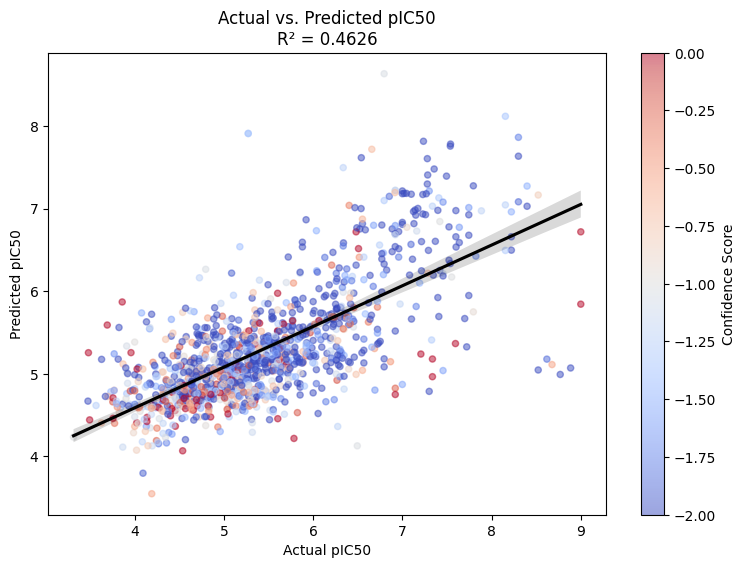

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with trendline and R²
plt.figure(figsize=(9, 6))
# Define a color map for confidence scores
cmap = sns.color_palette("coolwarm", as_cmap=True)
# Plot scatter plot with color mapping
sc = plt.scatter(results_df["Actual_pIC50"], results_df["Predicted_pIC50"],
                 c=results_df["Confidence_Score"], cmap=cmap, s=20, vmax=0, vmin=-2, alpha = 0.5)
# Add a color bar
cbar = plt.colorbar(sc)
cbar.set_label('Confidence Score')

# Add a trendline
sns.regplot(x="Actual_pIC50", y="Predicted_pIC50", data=results_df, scatter=False, color="black")

# Set labels and title
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title(f"Actual vs. Predicted pIC50\nR² = {test_r2:.4f}")

In [186]:
# 모델 초기화 함수
def initialize_weights(model):
    if isinstance(model, nn.Conv1d):
        nn.init.kaiming_normal_(model.weight.data, nonlinearity='relu')
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    elif isinstance(model, nn.Linear):
        nn.init.kaiming_normal_(model.weight.data, nonlinearity='relu')
        nn.init.constant_(model.bias.data, 0)

model = MultiKernel1DCNN(input_dim, num_filters, hidden_units, dropout_ratio)

In [149]:
# Optuna 하이퍼파라미터 최적화

import torch
import torch.nn as nn
import optuna

# Define the PyTorch model
class MultiKernel1DCNN(nn.Module):
    def __init__(self, input_dim, num_filters, hidden_units, dropout_ratio):
        super(MultiKernel1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size=3)
        self.conv2 = nn.Conv1d(input_dim, num_filters, kernel_size=4)
        self.conv3 = nn.Conv1d(input_dim, num_filters -1, kernel_size=5)
        self.dropout1 = nn.Dropout(dropout_ratio[0])
        self.dropout2 = nn.Dropout(dropout_ratio[1])
        self.fc1 = nn.Linear(num_filters * 3, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)
    
    def forward(self, x, confidence_score):
        x = self.dropout1(x)
        x1 = torch.relu(self.conv1(x)).max(dim=2)[0]
        x2 = torch.relu(self.conv2(x)).max(dim=2)[0]
        x3 = torch.relu(self.conv3(x)).max(dim=2)[0]
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.dropout2(x)
        x = torch.cat((x, confidence_score.unsqueeze(1)), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    num_filters = trial.suggest_int('num_filters', 32, 256)
    hidden_units = trial.suggest_int('hidden_units', 32, 256)
    dropout_ratio1 = trial.suggest_float('dropout_ratio1', 0.1, 1.0)
    dropout_ratio2 = trial.suggest_float('dropout_ratio2', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Instantiate the model
    model = MultiKernel1DCNN(input_dim=118, num_filters=num_filters, hidden_units=hidden_units, dropout_ratio=(dropout_ratio1, dropout_ratio2))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    num_epochs = 10
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for compound_name, embeddings, confidence_scores, labels in train_loader:
            optimizer.zero_grad()
            embeddings_padded = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
            outputs = model(embeddings_padded.permute(0, 2, 1), confidence_scores).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(labels)
        train_loss /= len(train_dataset)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for compound_name, embeddings, confidence_scores, labels in val_loader:
                embeddings_padded = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
                outputs = model(embeddings_padded.permute(0, 2, 1), confidence_scores).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * len(labels)
        val_loss /= len(val_dataset)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
    return best_val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-06-13 16:24:00,066] A new study created in memory with name: no-name-ee014352-e371-4a88-9da5-017377432ad4
[I 2024-06-13 16:24:27,485] Trial 0 finished with value: 1.4652983435840181 and parameters: {'num_filters': 223, 'hidden_units': 180, 'dropout_ratio1': 0.37859971952045024, 'dropout_ratio2': 0.6122154780794576, 'learning_rate': 4.447753338618965e-05}. Best is trial 0 with value: 1.4652983435840181.
[I 2024-06-13 16:24:57,626] Trial 1 finished with value: 1.1334793786446389 and parameters: {'num_filters': 226, 'hidden_units': 46, 'dropout_ratio1': 0.2684522039569212, 'dropout_ratio2': 0.4215769034339856, 'learning_rate': 0.0009271462182768582}. Best is trial 1 with value: 1.1334793786446389.
[I 2024-06-13 16:25:10,155] Trial 2 finished with value: 15.056601431112142 and parameters: {'num_filters': 71, 'hidden_units': 252, 'dropout_ratio1': 0.9166522463247457, 'dropout_ratio2': 0.16725946174082496, 'learning_rate': 0.0010418621933113337}. Best is trial 1 with value: 1.1334793

Best trial:
  Value: 0.6688460241460064
  Params: 
    num_filters: 79
    hidden_units: 37
    dropout_ratio1: 0.281925231098623
    dropout_ratio2: 0.46404123766185246
    learning_rate: 0.008188804895218144


# 2D CNN 기반 RASNET 구현

데이터셋 준비

In [84]:
# 데이터셋 준비 (300 * 118 크기로 embedding 고정)
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
import numpy as np
import json
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score

# PyTorch 데이터셋 구성
class Diffdock2DDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.compounds = dataframe["Compound_Name"].tolist()
        self.embeddings = dataframe["Embedding"].tolist()
        self.confidence_scores = dataframe["Confidence_Score"].tolist()
        self.labels = dataframe["pIC50"].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        compound_name = self.compounds[idx]
        embedding = self.embeddings[idx]

        # Check if the embedding needs to be loaded from JSON
        if isinstance(embedding, str):
            embedding = json.loads(embedding)

        # Convert embedding to tensor
        embedding = torch.tensor(embedding, dtype=torch.float32)

        # Check the size of the embedding and apply padding or cropping
        if embedding.size(0) < 300:
            padding_size = 300 - embedding.size(0)
            embedding = F.pad(embedding, (0, 0, 0, padding_size))  # pad=(left, right, top, bottom)
        elif embedding.size(0) > 300:
            embedding = embedding[:300, :]
        
        # Add channel dimension: (Height, Width) -> (1, Height, Width)
        embedding = embedding.unsqueeze(0)

        confidence_score = torch.tensor(self.confidence_scores[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return compound_name, embedding, confidence_score, label

# 사용자 정의 collate 함수
def custom_collate_fn(batch):
    compound_name, embeddings, confidence_scores, labels = zip(*batch)

    # 각각의 텐서를 리스트로 유지
    compound_name = list(compound_name)
    embeddings = torch.stack(embeddings)
    confidence_scores = torch.tensor(confidence_scores, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    return compound_name, embeddings, confidence_scores, labels

In [85]:
# Train/validation/test 구분, pIC50 기준 상위 10%는 set마다 적절히 배분되도록 설정, K-fold 교차 검증 사용
# pIC50 값 기준 상위 10% 데이터 골라내기
top_10_percent_threshold = df["pIC50"].quantile(0.9)
high_pIC50_df = df[df["pIC50"] >= top_10_percent_threshold]
low_pIC50_df = df[df["pIC50"] < top_10_percent_threshold]

# 상위 10% 데이터 분할
train_high_df, test_high_df = train_test_split(high_pIC50_df, test_size=0.3, random_state=42)

# 나머지 90% 데이터 분할
train_low_df, test_low_df = train_test_split(low_pIC50_df, test_size=0.3, random_state=42)

# 상위 10%와 나머지 90% 데이터 결합
train_val_df = pd.concat([train_high_df, train_low_df])
test_df = pd.concat([test_high_df, test_low_df])

# K-Fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 데이터셋 생성
train_val_dataset = Diffdock2DDataset(train_val_df)
test_dataset = Diffdock2DDataset(test_df)

# 데이터 로더 생성 (Test set)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# K-Fold 교차 검증을 위해 각 폴드에 대해 데이터 로더를 생성
for fold, (train_index, val_index) in enumerate(kf.split(train_val_df)):
    print(f'Fold {fold+1}')
    
    # Subset을 사용하여 훈련 세트와 검증 세트를 만듦
    train_subset = Subset(train_val_dataset, train_index)
    val_subset = Subset(train_val_dataset, val_index)
    
    # 데이터 로더 생성
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
 
# 데이터 로더 테스트
for compound_name, embeddings, confidence_scores, labels in train_loader:
    print(f'Number of samples in batch: {len(embeddings)}')
    for i, embedding in enumerate(embeddings):
        print(f'Embedding {i} shape: {embedding.shape}')
    print(f'Labels shape: {labels.shape}')
    break

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Number of samples in batch: 32
Embedding 0 shape: torch.Size([1, 300, 118])
Embedding 1 shape: torch.Size([1, 300, 118])
Embedding 2 shape: torch.Size([1, 300, 118])
Embedding 3 shape: torch.Size([1, 300, 118])
Embedding 4 shape: torch.Size([1, 300, 118])
Embedding 5 shape: torch.Size([1, 300, 118])
Embedding 6 shape: torch.Size([1, 300, 118])
Embedding 7 shape: torch.Size([1, 300, 118])
Embedding 8 shape: torch.Size([1, 300, 118])
Embedding 9 shape: torch.Size([1, 300, 118])
Embedding 10 shape: torch.Size([1, 300, 118])
Embedding 11 shape: torch.Size([1, 300, 118])
Embedding 12 shape: torch.Size([1, 300, 118])
Embedding 13 shape: torch.Size([1, 300, 118])
Embedding 14 shape: torch.Size([1, 300, 118])
Embedding 15 shape: torch.Size([1, 300, 118])
Embedding 16 shape: torch.Size([1, 300, 118])
Embedding 17 shape: torch.Size([1, 300, 118])
Embedding 18 shape: torch.Size([1, 300, 118])
Embedding 19 shape: torch.Size([1, 300, 118])
Embedding 20 shape: torc

In [86]:
df

,Compound_Name,Embedding,Confidence_Score,IC50,pIC50
0,50154658,"[[-5.279434, -9.275272, -20.931572, 6.4046726,...",-4.30,40.0,7.397940
1,50013195,"[[-13.279481, 23.520832, -30.285246, -30.85781...",0.39,30200.0,4.519993
2,51506623,"[[-34.503292, -22.311438, 3.5678558, -10.81585...",-0.93,5160.0,5.287350
3,51186451,"[[-2.0280612, -5.6282864, 11.301641, 6.223523,...",-3.81,4440.0,5.352617
4,50952940,"[[8.600163, -12.185278, 3.6991034, 19.640444, ...",-2.27,10400.0,4.982967
...,...,...,...,...,...
3901,51280842,"[[13.148821, -17.490395, 0.09890032, -15.39092...",-0.89,77000.0,4.113509
3902,50867313,"[[11.34329, 9.423429, 22.262724, -14.15183, 51...",-1.60,237000.0,3.625252
3903,50315589,"[[7.361655, 2.0958693, 1.5848894, -21.107552, ...",-2.42,1000.0,6.000000
3904,50713193,"[[16.291378, -18.42118, -19.86251, -17.165792,...",-1.33,480.0,6.318759


RASNET model 정의

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim

# Bottleneck 블록 정의 (ResNet50에서 사용)
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Changed to BatchNorm2d
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Changed to BatchNorm2d
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)  # Changed to BatchNorm2d
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet 모델 정의
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=512):
        super(CustomResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(256, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Changed to BatchNorm2d
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 511)
        self.fc_confidence = nn.Linear(511 + 1, num_classes) 
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),  # Changed to BatchNorm2d
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x, confidence_scores):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.cat((x, confidence_scores.unsqueeze(1)), dim=1)
        x = self.fc_confidence(x)
        x = self.dropout(x)

        return x

def custom_resnet50():
    return CustomResNet(Bottleneck, [3, 4, 6, 3])

# 모델 인스턴스화
model = custom_resnet50()

# CUDA 사용 가능하면 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet(
  (conv1): Conv2d(256, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

In [97]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 학습 함수
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for _, embeddings, confidence_scores, labels in dataloader:
        embeddings, confidence_scores, labels = embeddings.to(device), confidence_scores.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings, confidence_scores)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * embeddings.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


# 평가 함수
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds = []
    true_vals = []
    with torch.no_grad():
        for _, embeddings, confidence_scores, labels in dataloader:
            embeddings, confidence_scores, labels = embeddings.to(device), confidence_scores.to(device), labels.to(device)

            outputs = model(embeddings, confidence_scores)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * embeddings.size(0)
            preds.extend(outputs.cpu().numpy())
            true_vals.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, preds, true_vals


In [98]:
# 학습 및 평가 루프
num_epochs = 100
best_val_loss = float('inf')
model_save_dir = './model_checkpoints'
os.makedirs(model_save_dir, exist_ok=True)
patience = 10

for fold, (train_index, val_index) in enumerate(kf.split(train_val_df)):
    print(f'Fold {fold+1}')
    
    train_subset = Subset(train_val_dataset, train_index)
    val_subset = Subset(train_val_dataset, val_index)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

    # 모델, optimizer, criterion 초기화
    model = custom_resnet50()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    best_fold_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, preds, true_vals = evaluate_model(model, val_loader, criterion, device)
        val_mae = mean_absolute_error(preds, true_vals)

        print(f"Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        if val_loss < best_fold_loss:
            best_fold_loss = val_loss
            best_epoch = epoch + 1
            best_model_wts = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break
    
    # 폴드별 최적 모델 저장
    torch.save(best_model_wts, os.path.join(model_save_dir, f'best_resnet_model_fold_{fold+1}.pth'))

    if best_fold_loss < best_val_loss:
        best_val_loss = best_fold_loss
        best_fold = fold + 1

# 최적 폴드 모델 로드
best_model_path = os.path.join(model_save_dir, f'best_resnet_model_fold_{best_fold}.pth')
model.load_state_dict(torch.load(best_model_path))

# 테스트 세트에서 평가
test_loss, test_preds, test_true_vals = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

Fold 1


RuntimeError: Given groups=1, weight of size [64, 256, 7, 7], expected input[32, 1, 300, 118] to have 256 channels, but got 1 channels instead

In [99]:
# Load the best model for testing
best_model_path = os.path.join(model_save_dir, f'best_resnet_model.pth')
checkpoint = torch.load('best_resnet_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
best_epoch = checkpoint['epoch']
print(f"Loaded best model from epoch {best_epoch}")

RuntimeError: Error(s) in loading state_dict for CustomResNet:
	Missing key(s) in state_dict: "bn1.running_mean", "bn1.running_var", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc_confidence.weight", "fc_confidence.bias". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 256, 7, 7]).
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for layer2.0.downsample.0.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer2.0.downsample.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 1, 1]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for layer3.0.downsample.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for layer3.0.downsample.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for layer4.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for layer4.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 512]) from checkpoint, the shape in current model is torch.Size([511, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([511]).

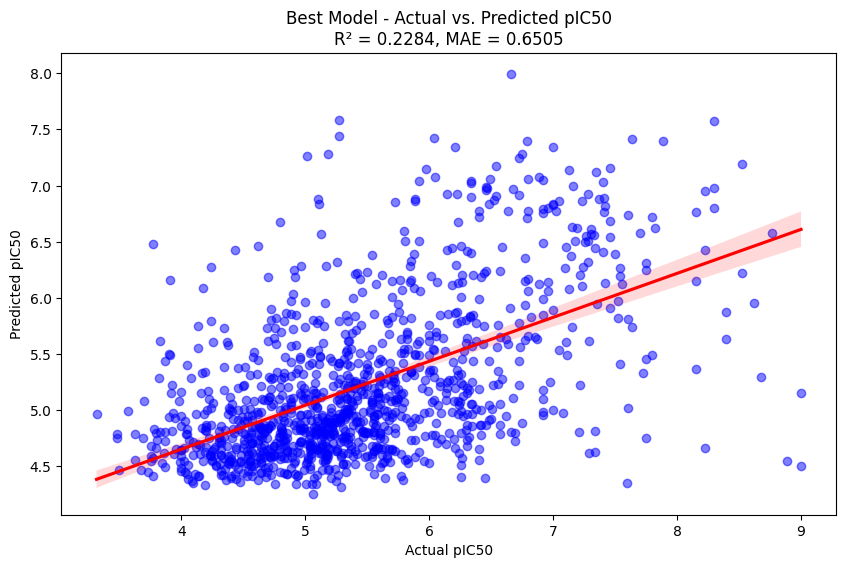

In [38]:
# 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

# Best 모델 결과 시각화
best_test_r2 = r2_score(test_labels, test_outputs)
best_test_mae = mean_absolute_error(test_labels, test_outputs)

plt.figure(figsize=(10, 6))
plt.scatter(test_labels, test_outputs, c='b', alpha=0.5)
sns.regplot(x=test_labels, y=test_outputs, scatter=False, color='r')
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title(f"Best Model - Actual vs. Predicted pIC50\nR² = {best_test_r2:.4f}, MAE = {best_test_mae:.4f}")
plt.show()

# Embedding visulaization

In [6]:
import matplotlib.pyplot as plt

def load_embeddings(directory):
    embeddings = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.startswith('final_embedding_') and file_name.endswith('.npy'):
            file_path = os.path.join(directory, file_name)
            embedding = np.load(file_path)
            embeddings.append(embedding)
    return embeddings

def load_initial_embeddings(directory):
    embeddings = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.startswith('initial_embeddings') and file_name.endswith('.npy'):
            file_path = os.path.join(directory, file_name)
            embedding = np.load(file_path)
            embeddings.append(embedding)
    return embeddings

def load_lignad_embeddings(directory):
    embeddings = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.startswith('final_embedding_ligand_') and file_name.endswith('.npy'):
            file_path = os.path.join(directory, file_name)
            embedding = np.load(file_path)
            embeddings.append(embedding)
    return embeddings

# 임베딩 import하기
embedding_directory = '/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test'  # 임베딩 파일들이 저장된 디렉토리 경로로 변경
embeddings = load_embeddings(embedding_directory)
initial_embeddings = load_initial_embeddings(embedding_directory)
ligand_embeddings = load_lignad_embeddings(embedding_directory)

In [8]:
# 각 임베딩 데이터의 shape 출력
print("Shapes of embeddings:", [e.shape for e in embeddings])
print("Shapes of initial embeddings:", [e.shape for e in initial_embeddings])
print("Shapes of ligand embeddings:", [e.shape for e in ligand_embeddings])

Shapes of embeddings: []
Shapes of initial embeddings: []
Shapes of ligand embeddings: []


In [ ]:
for i, embedding in enumerate(embeddings):
    print(embeddings[i].shape)

In [11]:
print(embeddings[1].shape)

(4321, 118)


In [22]:
embedding = np.load("/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/1a0q_1/final_embedding_1a0q_1.npy")
print(embedding.shape)

# Visualize the embedding as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(embedding, cmap='viridis', aspect='equal', vmin=-30, vmax=30)
plt.colorbar()
plt.title('Final Embedding Heatmap')
plt.show()

SyntaxError: invalid syntax (2203922523.py, line 5)

(214, 118)


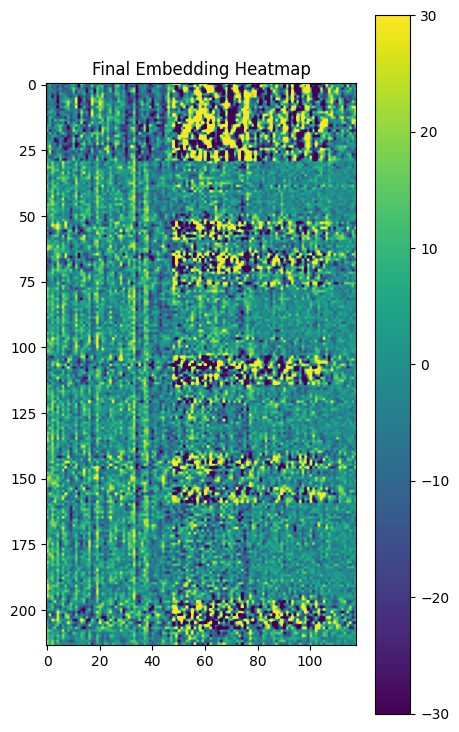

In [28]:
import numpy as np
import matplotlib.pyplot as plt

embedding = np.load("/home/serve/Gibeom/test/test2/DiffDock/results/gbnam_test/1a0q_5/final_embedding_1a0q_5.npy")
print(embedding.shape)

# 가로 길이를 고정하고 세로 길이를 데이터 비율에 맞게 조절
fixed_width = 5
aspect_ratio = embedding.shape[0] / embedding.shape[1]
fig_height = fixed_width * aspect_ratio

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(fixed_width, fig_height))
cax = ax.imshow(embedding, cmap='viridis', aspect='equal', vmin=-30, vmax=30)
fig.colorbar(cax)
ax.set_title('Final Embedding Heatmap')
plt.show()

UnboundLocalError: local variable 'i' referenced before assignment

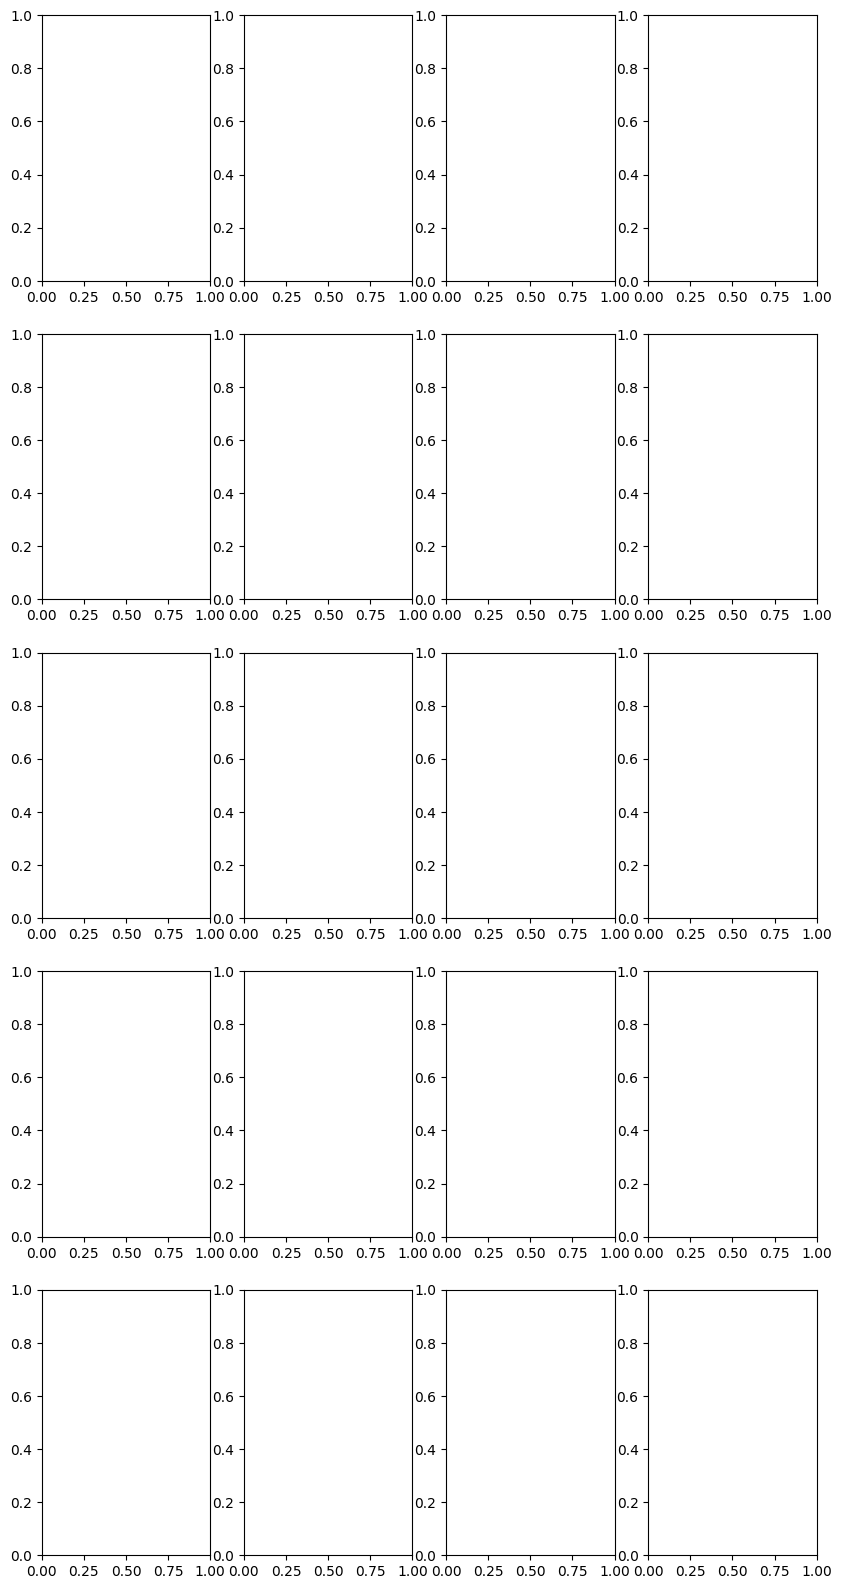

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, title, nrows=5, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20))
    axes = axes.flatten()
    
    for i, embedding in enumerate(embeddings):
        if i >= nrows * ncols:
            break
        im = axes[i].imshow(embedding, cmap='viridis', aspect='auto', vmin=-40, vmax=40)
        axes[i].set_title(f'{title} {i+1}', fontsize= 8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        fig.colorbar(im, ax=axes[i])
    
    # Hide any remaining empty subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# 리간드 임베딩을 히트맵으로 시각화
visualize_embeddings(ligand_embeddings, 'Ligand Embedding')


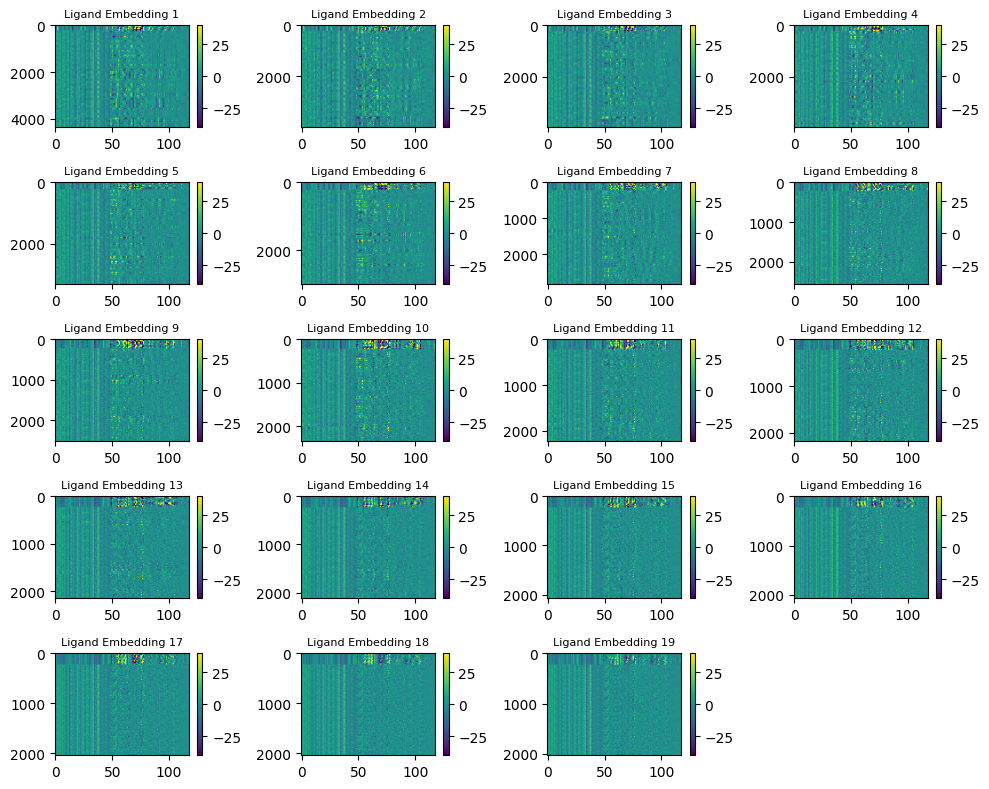

In [7]:
# 리간드 임베딩을 히트맵으로 시각화
visualize_embeddings(embeddings, 'Ligand Embedding')

In [3]:
torch.cuda.is_available()

True